# Clasificaci√≥n de Im√°genes Histopatol√≥gicas de Osteosarcoma

Comparaci√≥n de 4 modelos de Deep Learning: VGG16, ResNet50, MobileNetV2, EfficientNetB0

### Obtener librer√≠as necesarias

In [1]:
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn Pillow opencv-python tqdm statsmodels ipywidgets

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1.6/1.6 MB 32.0 MB/s eta 0:00:00


### Configuraci√≥n de rutas

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import PIL
from PIL import Image
from tqdm.notebook import tqdm
import cv2
import gc

# Para la prueba de McNemar
from statsmodels.stats.contingency_tables import mcnemar

# Aseg√∫rate de tener la GPU activada
print("GPU disponible:", tf.test.is_gpu_available())
print("Dispositivos TensorFlow:", tf.config.list_physical_devices('GPU'))

# Funci√≥n para montar Google Drive si estamos en Colab
try:
    from google.colab import drive
    IN_COLAB = True
    print("Ejecutando en Google Colab. Montando Google Drive...")
    drive.mount('/content/drive')
    # Cambiar al directorio correspondiente si es necesario
    %cd /content/drive/MyDrive/Datasets/Osteosarcoma/
except:
    IN_COLAB = False
    print("No estamos ejecutando en Google Colab")

# Configurar rutas
# Ajusta estas rutas seg√∫n donde tengas tus datos
DATA_DIR = '/content/drive/MyDrive/Datasets/Osteosarcoma/images'  # Carpeta con las im√°genes
CSV_PATH = '/content/drive/MyDrive/Datasets/Osteosarcoma/ML_Features.csv'  # Ruta al archivo CSV

# Liberar memoria GPU si es necesario
def clear_memory():
    gc.collect()
    tf.keras.backend.clear_session()
    print("Memoria liberada")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU disponible: True
Dispositivos TensorFlow: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Ejecutando en Google Colab. Montando Google Drive...
Mounted at /content/drive
/content/drive/MyDrive/Datasets/Osteosarcoma


### Carga y preprocesamiento de datos

In [3]:
# Cargar el CSV con las etiquetas
df = pd.read_csv(CSV_PATH)

# Mostramos las primeras filas para entender la estructura
print("Primeras filas del dataset:")
df.head()

# Informaci√≥n sobre el dataset
print("\nInformaci√≥n del dataset:")
df.info()

# Verificar las clases disponibles
print("\nClases disponibles:", df['classification'].unique())
print("Distribuci√≥n de clases:")
print(df['classification'].value_counts())

# Corregir los nombres de archivo como se solicita
df['image_path'] = df['image.name'].astype(str).str.replace(' - ', '-').str.replace(' ','-') + '.jpg'

# Verificar que el formato de las rutas de las im√°genes sea el correcto
print("\nEjemplos de rutas de im√°genes:")
print(df['image_path'].head())

# Codificar las labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['classification'])

# Mapeo de las clases
class_mapping = {idx: label for idx, label in enumerate(label_encoder.classes_)}
print("\nMapeo de clases:", class_mapping)

# Verificar si todas las im√°genes existen
def check_images_exist(data_dir, df):
    missing_images = []
    for img_path in df['image_path']:
        full_path = os.path.join(data_dir, img_path)
        if not os.path.exists(full_path):
            missing_images.append(img_path)

    if missing_images:
        print(f"¬°Advertencia! {len(missing_images)} im√°genes no encontradas:")
        print(missing_images[:5], "..." if len(missing_images) > 5 else "")
    else:
        print("Todas las im√°genes est√°n disponibles.")

    return missing_images

missing_images = check_images_exist(DATA_DIR, df)

# Filtrar filas con im√°genes faltantes
if missing_images:
    df = df[~df['image_path'].isin(missing_images)]
    print(f"Dataset filtrado: {len(df)} im√°genes disponibles")

# Dividir en conjuntos de entrenamiento y validaci√≥n (70% / 30%)
train_df, val_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['classification'],
    random_state=42
)

print(f"\nConjunto de entrenamiento: {len(train_df)} im√°genes")
print(f"Conjunto de validaci√≥n: {len(val_df)} im√°genes")

# Verificar la distribuci√≥n de clases en los conjuntos de entrenamiento y validaci√≥n
print("\nDistribuci√≥n de clases en el conjunto de entrenamiento:")
print(train_df['classification'].value_counts())
print("\nDistribuci√≥n de clases en el conjunto de validaci√≥n:")
print(val_df['classification'].value_counts())

Primeras filas del dataset:

Informaci√≥n del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1144 entries, 0 to 1143
Data columns (total 69 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     1144 non-null   int64  
 1   image.name                             1144 non-null   object 
 2   X.x                                    1144 non-null   int64  
 3   Blue.count                             1144 non-null   int64  
 4   red.count                              1144 non-null   int64  
 5   Blue.percentage                        1144 non-null   float64
 6   red.percentage                         1144 non-null   float64
 7   total.clusters                         1144 non-null   int64  
 8   average.clusters.32                    1144 non-null   float64
 9   area                                   1143 non-null   float64
 10  circularity      

### Funciones para cargar y preprocesar im√°genes

Cargando im√°genes de entrenamiento...


  0%|          | 0/800 [00:00<?, ?it/s]

Cargando im√°genes de validaci√≥n...


  0%|          | 0/344 [00:00<?, ?it/s]

X_train shape: (800, 224, 224, 3)
X_val shape: (344, 224, 224, 3)
N√∫mero de clases: 4


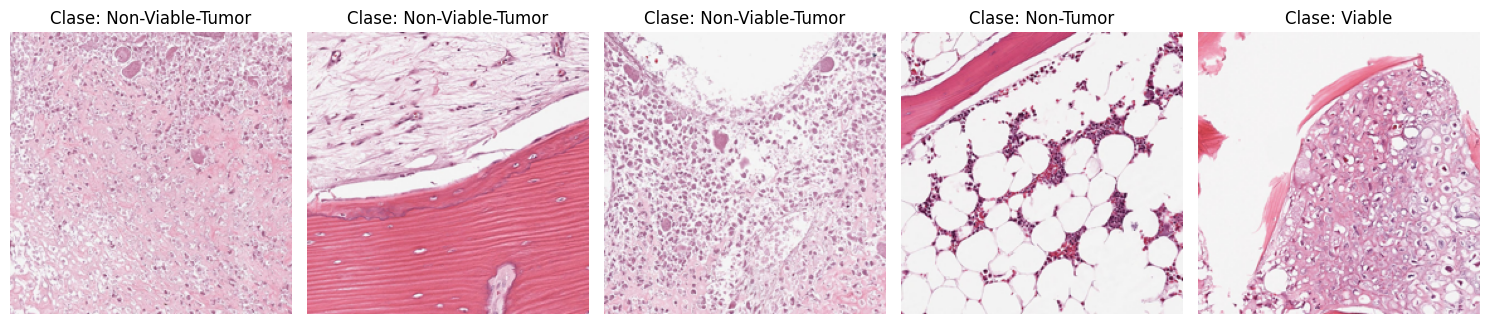

In [4]:
# Funci√≥n para cargar y redimensionar im√°genes
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    try:
        full_path = os.path.join(DATA_DIR, image_path)
        img = Image.open(full_path)
        img = img.resize(target_size)
        img_array = np.array(img)

        # Asegurarse de que la imagen tiene 3 canales (RGB)
        if len(img_array.shape) == 2:
            img_array = np.stack([img_array, img_array, img_array], axis=-1)
        elif img_array.shape[2] == 1:
            img_array = np.concatenate([img_array, img_array, img_array], axis=-1)
        elif img_array.shape[2] == 4:  # RGBA
            img_array = img_array[:, :, :3]

        return img_array
    except Exception as e:
        print(f"Error cargando imagen {image_path}: {e}")
        return None

# Cargar todas las im√°genes
print("Cargando im√°genes de entrenamiento...")
X_train = []
y_train = []
for idx, row in tqdm(train_df.iterrows(), total=len(train_df)):
    img = load_and_preprocess_image(row['image_path'])
    if img is not None:
        X_train.append(img)
        y_train.append(row['label_encoded'])

print("Cargando im√°genes de validaci√≥n...")
X_val = []
y_val = []
for idx, row in tqdm(val_df.iterrows(), total=len(val_df)):
    img = load_and_preprocess_image(row['image_path'])
    if img is not None:
        X_val.append(img)
        y_val.append(row['label_encoded'])

# Convertir a arrays de numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")

# Crear generators para data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator()

# N√∫mero de clases
num_classes = len(label_encoder.classes_)
print(f"N√∫mero de clases: {num_classes}")

# Visualizar algunas im√°genes para verificar
def visualize_samples(X, y, class_mapping, n_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+1)
        plt.imshow(X[i].astype('uint8'))
        plt.title(f"Clase: {class_mapping[y[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_samples(X_train, y_train, class_mapping)

### Definici√≥n de los modelos

In [5]:
# 1. Modelo VGG16
def create_vgg16_model(input_shape=(224, 224, 3), num_classes=4):
    # Cargar modelo base pre-entrenado
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas convolucionales
    for layer in base_model.layers:
        layer.trainable = False

    # A√±adir capas para clasificaci√≥n
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 2. Modelo ResNet50
def create_resnet50_model(input_shape=(224, 224, 3), num_classes=4):
    # Cargar modelo base pre-entrenado
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas convolucionales
    for layer in base_model.layers:
        layer.trainable = False

    # A√±adir capas para clasificaci√≥n
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 3. Modelo MobileNetV2
def create_mobilenetv2_model(input_shape=(224, 224, 3), num_classes=4):
    # Cargar modelo base pre-entrenado
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas convolucionales
    for layer in base_model.layers:
        layer.trainable = False

    # A√±adir capas para clasificaci√≥n
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 4. Modelo EfficientNetB0
def create_efficientnetb0_model(input_shape=(224, 224, 3), num_classes=4):
    # Cargar modelo base pre-entrenado
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas convolucionales
    for layer in base_model.layers:
        layer.trainable = False

    # A√±adir capas para clasificaci√≥n
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compilar
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

### Funci√≥n para entrenar los modelos

In [6]:
# Funci√≥n para entrenar los modelos con verificaci√≥n de existencia previa
def train_model(model, model_name, X_train, y_train, X_val, y_val,
                preprocessing_func=None, batch_size=32, epochs=30):

    # Verificar si ya existe un modelo entrenado
    model_path = f'{model_name}.h5'
    if os.path.exists(model_path):
        print(f"Modelo pre-entrenado encontrado en {model_path}. Cargando modelo...")
        loaded_model = load_model(model_path)
        # Return an empty history dictionary when loading a model
        return loaded_model, {}

    print(f"No se encontr√≥ modelo pre-entrenado. Entrenando {model_name}...")

    # Callbacks para mejorar el entrenamiento
    checkpoint = ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        verbose=1,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    callbacks = [checkpoint, early_stopping, reduce_lr]

    # Preprocesamiento para los modelos CNN
    if preprocessing_func:
        # Crear generadores con funci√≥n de preprocesamiento
        train_datagen_with_preproc = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=preprocessing_func
        )

        val_datagen_with_preproc = ImageDataGenerator(
            preprocessing_function=preprocessing_func
        )

        train_gen = train_datagen_with_preproc.flow(
            X_train, y_train,
            batch_size=batch_size,
            shuffle=True
        )

        val_gen = val_datagen_with_preproc.flow(
            X_val, y_val,
            batch_size=batch_size,
            shuffle=False
        )
    else:
        # Generadores est√°ndar con normalizaci√≥n simple
        train_datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            rescale=1./255
        )

        val_datagen = ImageDataGenerator(rescale=1./255)

        train_gen = train_datagen.flow(
            X_train, y_train,
            batch_size=batch_size,
            shuffle=True
        )

        val_gen = val_datagen.flow(
            X_val, y_val,
            batch_size=batch_size,
            shuffle=False
        )

    # Entrenar el modelo
    history = model.fit(
        train_gen,
        steps_per_epoch=len(X_train) // batch_size,
        epochs=epochs,
        validation_data=val_gen,
        validation_steps=len(X_val) // batch_size,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

### Entrenamiento de los modelos

In [7]:
# Entrenamos los 4 modelos
models = {}
histories = {}
batch_size = 32
epochs = 100  # M√°ximo de 100 epochs, para prevenir overfitting, puede terminarse antes

# 1. VGG16
print("\n=== Entrenando VGG16 ===")
clear_memory()
vgg16_model = create_vgg16_model(num_classes=num_classes)
vgg16_model, vgg16_history = train_model(
    vgg16_model, 'vgg16_osteosarcoma',
    X_train, y_train, X_val, y_val,
    preprocessing_func=vgg_preprocess,
    batch_size=batch_size, epochs=epochs
)
models['VGG16'] = vgg16_model
histories['VGG16'] = vgg16_history

# 2. ResNet50
print("\n=== Entrenando ResNet50 ===")
clear_memory()
resnet50_model = create_resnet50_model(num_classes=num_classes)
resnet50_model, resnet50_history = train_model(
    resnet50_model, 'resnet50_osteosarcoma',
    X_train, y_train, X_val, y_val,
    preprocessing_func=resnet_preprocess,
    batch_size=batch_size, epochs=epochs
)
models['ResNet50'] = resnet50_model
histories['ResNet50'] = resnet50_history

# 3. MobileNetV2
print("\n=== Entrenando MobileNetV2 ===")
clear_memory()
mobilenetv2_model = create_mobilenetv2_model(num_classes=num_classes)
mobilenetv2_model, mobilenetv2_history = train_model(
    mobilenetv2_model, 'mobilenetv2_osteosarcoma',
    X_train, y_train, X_val, y_val,
    preprocessing_func=mobilenet_preprocess,
    batch_size=batch_size, epochs=epochs
)
models['MobileNetV2'] = mobilenetv2_model
histories['MobileNetV2'] = mobilenetv2_history

# 4. EfficientNetB0
print("\n=== Entrenando EfficientNetB0 ===")
clear_memory()
efficientnetb0_model = create_efficientnetb0_model(num_classes=num_classes)
efficientnetb0_model, efficientnetb0_history = train_model(
    efficientnetb0_model, 'efficientnetb0_osteosarcoma',
    X_train, y_train, X_val, y_val,
    preprocessing_func=efficientnet_preprocess,
    batch_size=batch_size, epochs=epochs
)
models['EfficientNetB0'] = efficientnetb0_model
histories['EfficientNetB0'] = efficientnetb0_history

# Guardar todos los modelos en formato H5 (si no fueron cargados)
for name, model in models.items():
    model_path = f'{name}_osteosarcoma.h5'
    if not os.path.exists(model_path):
        model.save(model_path)
        print(f"Modelo {name} guardado en {model_path}")
    else:
        print(f"El modelo {name} ya existe en {model_path}")


=== Entrenando VGG16 ===
Memoria liberada
58889256/58889256 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 0us/step
No se encontr√≥ modelo pre-entrenado. Entrenando vgg16_osteosarcoma...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 428ms/step - accuracy: 0.3398 - loss: 4.3314
Epoch 1: val_accuracy improved from -inf to 0.57812, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 540ms/step - accuracy: 0.3414 - loss: 4.3086 - val_accuracy: 0.5781 - val_loss: 1.3594 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 442ms/step - accuracy: 0.5326 - loss: 2.2428
Epoch 2: val_accuracy improved from 0.57812 to 0.75000, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 1s/step - accuracy: 0.5332 - loss: 2.2419 - val_accuracy: 0.7500 - val_loss: 0.9162 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 372ms/step - accuracy: 0.5711 - loss: 2.1092
Epoch 3: val_accuracy improved from 0.75000 to 0.80937, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 496ms/step - accuracy: 0.5731 - loss: 2.0971 - val_accuracy: 0.8094 - val_loss: 0.7496 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 454ms/step - accuracy: 0.6704 - loss: 1.5526
Epoch 4: val_accuracy improved from 0.80937 to 0.83438, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 570ms/step - accuracy: 0.6706 - loss: 1.5535 - val_accuracy: 0.8344 - val_loss: 0.6989 - learning_rate: 1.0000e-04
Epoch 5/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 439ms/step - accuracy: 0.7291 - loss: 1.2399
Epoch 5: val_accuracy improved from 0.83438 to 0.84688, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 568ms/step - accuracy: 0.7287 - loss: 1.2425 - val_accuracy: 0.8469 - val_loss: 0.6283 - learning_rate: 1.0000e-04
Epoch 6/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 443ms/step - accuracy: 0.7361 - loss: 1.2305
Epoch 6: val_accuracy improved from 0.84688 to 0.85312, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 571ms/step - accuracy: 0.7367 - loss: 1.2261 - val_accuracy: 0.8531 - val_loss: 0.6151 - learning_rate: 1.0000e-04
Epoch 7/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 432ms/step - accuracy: 0.7441 - loss: 1.0345
Epoch 7: val_accuracy did not improve from 0.85312
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 503ms/step - accuracy: 0.7441 - loss: 1.0332 - val_accuracy: 0.8531 - val_loss: 0.5905 - learning_rate: 1.0000e-04
Epoch 8/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 433ms/step - accuracy: 0.7632 - loss: 0.9863
Epoch 8: val_accuracy improved from 0.85312 to 0.86563, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 550ms/step - accuracy: 0.7628 - loss: 0.9857 - val_accuracy: 0.8656 - val_loss: 0.5645 - learning_rate: 1.0000e-04
Epoch 9/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 441ms/step - accuracy: 0.7751 - loss: 0.8921
Epoch 9: val_accuracy improved from 0.86563 to 0.86875, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 836ms/step - accuracy: 0.7753 - loss: 0.8915 - val_accuracy: 0.8687 - val_loss: 0.5511 - learning_rate: 1.0000e-04
Epoch 10/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 388ms/step - accuracy: 0.7574 - loss: 0.9194
Epoch 10: val_accuracy improved from 0.86875 to 0.87500, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 33s 502ms/step - accuracy: 0.7575 - loss: 0.9182 - val_accuracy: 0.8750 - val_loss: 0.5224 - learning_rate: 1.0000e-04
Epoch 11/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 384ms/step - accuracy: 0.7797 - loss: 0.8317
Epoch 11: val_accuracy did not improve from 0.87500
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 789ms/step - accuracy: 0.7798 - loss: 0.8313 - val_accuracy: 0.8750 - val_loss: 0.5373 - learning_rate: 1.0000e-04
Epoch 12/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 435ms/step - accuracy: 0.8049 - loss: 0.7667
Epoch 12: val_accuracy improved from 0.87500 to 0.87813, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 878ms/step - accuracy: 0.8047 - loss: 0.7661 - val_accuracy: 0.8781 - val_loss: 0.5049 - learning_rate: 1.0000e-04
Epoch 13/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 452ms/step - accuracy: 0.8203 - loss: 0.6057
Epoch 13: val_accuracy improved from 0.87813 to 0.88125, saving model to vgg16_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 531ms/step - accuracy: 0.8200 - loss: 0.6065 - val_accuracy: 0.8813 - val_loss: 0.4939 - learning_rate: 1.0000e-04
Epoch 14/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 449ms/step - accuracy: 0.8113 - loss: 0.6469
Epoch 14: val_accuracy did not improve from 0.88125
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 518ms/step - accuracy: 0.8112 - loss: 0.6470 - val_accuracy: 0.8656 - val_loss: 0.5410 - learning_rate: 1.0000e-04
Epoch 15/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 430ms/step - accuracy: 0.8543 - loss: 0.5801
Epoch 15: val_accuracy did not improve from 0.88125
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 500ms/step - accuracy: 0.8536 - loss: 0.5821 - val_accuracy: 0.8813 - val_loss: 0.4959 - learning_rate: 1.0000e-04
Epoch 16/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 548ms/step - accuracy: 0.8207 - loss: 0.5856 - val_accuracy: 0.8844 - val_loss: 0.4525 - learning_rate: 1.0000e-04
Epoch 21/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 446ms/step - accuracy: 0.8379 - loss: 0.5621
Epoch 21: val_accuracy did not improve from 0.88437
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 517ms/step - accuracy: 0.8380 - loss: 0.5607 - val_accuracy: 0.8813 - val_loss: 0.4460 - learning_rate: 1.0000e-04
Epoch 22/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 427ms/step - accuracy: 0.8341 - loss: 0.5402
Epoch 22: val_accuracy did not improve from 0.88437
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 513ms/step - accuracy: 0.8340 - loss: 0.5396 - val_accuracy: 0.8719 - val_loss: 0.4753 - learning_rate: 1.0000e-04
Epoch 23/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 28s 616ms/step - accuracy: 0.4351 - loss: 1.5836 - val_accuracy: 0.7719 - val_loss: 0.6465 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 375ms/step - accuracy: 0.7425 - loss: 0.7203
Epoch 2: val_accuracy improved from 0.77188 to 0.83125, saving model to resnet50_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 482ms/step - accuracy: 0.7435 - loss: 0.7172 - val_accuracy: 0.8313 - val_loss: 0.5205 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 415ms/step - accuracy: 0.8014 - loss: 0.5806
Epoch 3: val_accuracy improved from 0.83125 to 0.85625, saving model to resnet50_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 485ms/step - accuracy: 0.8016 - loss: 0.5801 - val_accuracy: 0.8562 - val_loss: 0.4739 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 431ms/step - accuracy: 0.7993 - loss: 0.5622
Epoch 4: val_accuracy improved from 0.85625 to 0.87813, saving model to resnet50_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 27s 1s/step - accuracy: 0.8000 - loss: 0.5609 - val_accuracy: 0.8781 - val_loss: 0.4330 - learning_rate: 1.0000e-04
Epoch 5/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 429ms/step - accuracy: 0.8639 - loss: 0.4072
Epoch 5: val_accuracy did not improve from 0.87813
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 517ms/step - accuracy: 0.8634 - loss: 0.4083 - val_accuracy: 0.8750 - val_loss: 0.4165 - learning_rate: 1.0000e-04
Epoch 6/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 411ms/step - accuracy: 0.8743 - loss: 0.3919
Epoch 6: val_accuracy did not improve from 0.87813
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 454ms/step - accuracy: 0.8741 - loss: 0.3920 - val_accuracy: 0.8719 - val_loss: 0.3898 - learning_rate: 1.0000e-04
Epoch 7/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 368ms/s

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 495ms/step - accuracy: 0.8708 - loss: 0.3948 - val_accuracy: 0.8875 - val_loss: 0.3578 - learning_rate: 1.0000e-04
Epoch 8/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 437ms/step - accuracy: 0.8500 - loss: 0.4035
Epoch 8: val_accuracy did not improve from 0.88750
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 473ms/step - accuracy: 0.8506 - loss: 0.4030 - val_accuracy: 0.8719 - val_loss: 0.3904 - learning_rate: 1.0000e-04
Epoch 9/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 346ms/step - accuracy: 0.8663 - loss: 0.3550
Epoch 9: val_accuracy did not improve from 0.88750
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 477ms/step - accuracy: 0.8662 - loss: 0.3550 - val_accuracy: 0.8813 - val_loss: 0.3837 - learning_rate: 1.0000e-04
Epoch 10/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 355

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 34s 536ms/step - accuracy: 0.8775 - loss: 0.3169 - val_accuracy: 0.8938 - val_loss: 0.3447 - learning_rate: 1.0000e-04
Epoch 14/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 422ms/step - accuracy: 0.8704 - loss: 0.3078
Epoch 14: val_accuracy improved from 0.89375 to 0.89688, saving model to resnet50_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 496ms/step - accuracy: 0.8708 - loss: 0.3082 - val_accuracy: 0.8969 - val_loss: 0.3228 - learning_rate: 1.0000e-04
Epoch 15/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 422ms/step - accuracy: 0.8818 - loss: 0.3230
Epoch 15: val_accuracy did not improve from 0.89688
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 802ms/step - accuracy: 0.8818 - loss: 0.3235 - val_accuracy: 0.8906 - val_loss: 0.3248 - learning_rate: 1.0000e-04
Epoch 16/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 376ms/step - accuracy: 0.8839 - loss: 0.3047
Epoch 16: val_accuracy did not improve from 0.89688
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 418ms/step - accuracy: 0.8837 - loss: 0.3049 - val_accuracy: 0.8938 - val_loss: 0.3193 - learning_rate: 1.0000e-04
Epoch 17/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 542ms/step - accuracy: 0.3384 - loss: 1.8130 - val_accuracy: 0.6531 - val_loss: 0.9049 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 372ms/step - accuracy: 0.6542 - loss: 0.9413
Epoch 2: val_accuracy improved from 0.65312 to 0.74375, saving model to mobilenetv2_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 436ms/step - accuracy: 0.6544 - loss: 0.9402 - val_accuracy: 0.7437 - val_loss: 0.7023 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 392ms/step - accuracy: 0.7393 - loss: 0.7379
Epoch 3: val_accuracy did not improve from 0.74375
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 413ms/step - accuracy: 0.7390 - loss: 0.7387 - val_accuracy: 0.7250 - val_loss: 0.6831 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 320ms/step - accuracy: 0.7147 - loss: 0.7958
Epoch 4: val_accuracy improved from 0.74375 to 0.78750, saving model to mobilenetv2_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 461ms/step - accuracy: 0.7166 - loss: 0.7929 - val_accuracy: 0.7875 - val_loss: 0.5936 - learning_rate: 1.0000e-04
Epoch 5/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 339ms/step - accuracy: 0.7687 - loss: 0.6564
Epoch 5: val_accuracy did not improve from 0.78750
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 362ms/step - accuracy: 0.7690 - loss: 0.6567 - val_accuracy: 0.7812 - val_loss: 0.5782 - learning_rate: 1.0000e-04
Epoch 6/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 393ms/step - accuracy: 0.7803 - loss: 0.6591
Epoch 6: val_accuracy did not improve from 0.78750
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 412ms/step - accuracy: 0.7809 - loss: 0.6567 - val_accuracy: 0.7781 - val_loss: 0.5819 - learning_rate: 1.0000e-04
Epoch 7/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 357ms

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 427ms/step - accuracy: 0.8078 - loss: 0.5702 - val_accuracy: 0.8125 - val_loss: 0.5305 - learning_rate: 1.0000e-04
Epoch 8/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 367ms/step - accuracy: 0.8272 - loss: 0.5339
Epoch 8: val_accuracy improved from 0.81250 to 0.82187, saving model to mobilenetv2_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 426ms/step - accuracy: 0.8267 - loss: 0.5335 - val_accuracy: 0.8219 - val_loss: 0.5018 - learning_rate: 1.0000e-04
Epoch 9/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 396ms/step - accuracy: 0.8370 - loss: 0.5154
Epoch 9: val_accuracy improved from 0.82187 to 0.84688, saving model to mobilenetv2_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 454ms/step - accuracy: 0.8370 - loss: 0.5149 - val_accuracy: 0.8469 - val_loss: 0.5024 - learning_rate: 1.0000e-04
Epoch 10/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 343ms/step - accuracy: 0.8221 - loss: 0.5420
Epoch 10: val_accuracy improved from 0.84688 to 0.85938, saving model to mobilenetv2_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 400ms/step - accuracy: 0.8224 - loss: 0.5404 - val_accuracy: 0.8594 - val_loss: 0.4635 - learning_rate: 1.0000e-04
Epoch 11/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 321ms/step - accuracy: 0.8686 - loss: 0.4114
Epoch 11: val_accuracy did not improve from 0.85938
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 339ms/step - accuracy: 0.8674 - loss: 0.4136 - val_accuracy: 0.8594 - val_loss: 0.4650 - learning_rate: 1.0000e-04
Epoch 12/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 393ms/step - accuracy: 0.8591 - loss: 0.4340
Epoch 12: val_accuracy did not improve from 0.85938
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 414ms/step - accuracy: 0.8595 - loss: 0.4331 - val_accuracy: 0.8594 - val_loss: 0.4508 - learning_rate: 1.0000e-04
Epoch 13/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 454ms/step - accuracy: 0.8559 - loss: 0.4068 - val_accuracy: 0.8656 - val_loss: 0.4363 - learning_rate: 1.0000e-04
Epoch 14/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 369ms/step - accuracy: 0.8610 - loss: 0.4172
Epoch 14: val_accuracy improved from 0.86563 to 0.87187, saving model to mobilenetv2_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 456ms/step - accuracy: 0.8610 - loss: 0.4171 - val_accuracy: 0.8719 - val_loss: 0.4317 - learning_rate: 1.0000e-04
Epoch 15/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 395ms/step - accuracy: 0.8511 - loss: 0.4699
Epoch 15: val_accuracy did not improve from 0.87187
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 412ms/step - accuracy: 0.8514 - loss: 0.4686 - val_accuracy: 0.8656 - val_loss: 0.4512 - learning_rate: 1.0000e-04
Epoch 16/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 389ms/step - accuracy: 0.8498 - loss: 0.4389
Epoch 16: val_accuracy did not improve from 0.87187
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 417ms/step - accuracy: 0.8502 - loss: 0.4375 - val_accuracy: 0.8719 - val_loss: 0.4222 - learning_rate: 1.0000e-04
Epoch 17/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 450ms/step - accuracy: 0.8622 - loss: 0.3765 - val_accuracy: 0.8781 - val_loss: 0.4211 - learning_rate: 1.0000e-04
Epoch 20/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 350ms/step - accuracy: 0.8554 - loss: 0.3863
Epoch 20: val_accuracy improved from 0.87813 to 0.88125, saving model to mobilenetv2_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 449ms/step - accuracy: 0.8559 - loss: 0.3858 - val_accuracy: 0.8813 - val_loss: 0.4071 - learning_rate: 1.0000e-04
Epoch 21/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 378ms/step - accuracy: 0.8599 - loss: 0.3736
Epoch 21: val_accuracy did not improve from 0.88125
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 399ms/step - accuracy: 0.8598 - loss: 0.3737 - val_accuracy: 0.8813 - val_loss: 0.3917 - learning_rate: 1.0000e-04
Epoch 22/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 391ms/step - accuracy: 0.8895 - loss: 0.3167
Epoch 22: val_accuracy improved from 0.88125 to 0.88750, saving model to mobilenetv2_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 447ms/step - accuracy: 0.8887 - loss: 0.3184 - val_accuracy: 0.8875 - val_loss: 0.4016 - learning_rate: 1.0000e-04
Epoch 23/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 367ms/step - accuracy: 0.8477 - loss: 0.3919
Epoch 23: val_accuracy did not improve from 0.88750
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 385ms/step - accuracy: 0.8480 - loss: 0.3917 - val_accuracy: 0.8813 - val_loss: 0.3977 - learning_rate: 1.0000e-04
Epoch 24/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 334ms/step - accuracy: 0.8947 - loss: 0.3160
Epoch 24: val_accuracy did not improve from 0.88750
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 351ms/step - accuracy: 0.8942 - loss: 0.3173 - val_accuracy: 0.8813 - val_loss: 0.3949 - learning_rate: 1.0000e-04
Epoch 25/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 392ms/step - accuracy: 0.8901 - loss: 0.2951 - val_accuracy: 0.8906 - val_loss: 0.3752 - learning_rate: 1.0000e-04
Epoch 32/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 390ms/step - accuracy: 0.8764 - loss: 0.3259
Epoch 32: val_accuracy did not improve from 0.89062
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 409ms/step - accuracy: 0.8765 - loss: 0.3260 - val_accuracy: 0.8781 - val_loss: 0.3806 - learning_rate: 1.0000e-04
Epoch 33/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 391ms/step - accuracy: 0.8715 - loss: 0.3433
Epoch 33: val_accuracy did not improve from 0.89062
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 414ms/step - accuracy: 0.8719 - loss: 0.3417 - val_accuracy: 0.8781 - val_loss: 0.3638 - learning_rate: 1.0000e-04
Epoch 34/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 38s 660ms/step - accuracy: 0.4671 - loss: 1.2009 - val_accuracy: 0.6938 - val_loss: 0.9028 - learning_rate: 1.0000e-04
Epoch 2/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 394ms/step - accuracy: 0.6914 - loss: 0.8907
Epoch 2: val_accuracy improved from 0.69375 to 0.72812, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 727ms/step - accuracy: 0.6920 - loss: 0.8888 - val_accuracy: 0.7281 - val_loss: 0.7750 - learning_rate: 1.0000e-04
Epoch 3/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 332ms/step - accuracy: 0.7487 - loss: 0.7221
Epoch 3: val_accuracy improved from 0.72812 to 0.77188, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 383ms/step - accuracy: 0.7488 - loss: 0.7220 - val_accuracy: 0.7719 - val_loss: 0.6907 - learning_rate: 1.0000e-04
Epoch 4/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 377ms/step - accuracy: 0.7883 - loss: 0.6624
Epoch 4: val_accuracy improved from 0.77188 to 0.78438, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 424ms/step - accuracy: 0.7877 - loss: 0.6625 - val_accuracy: 0.7844 - val_loss: 0.6441 - learning_rate: 1.0000e-04
Epoch 5/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 390ms/step - accuracy: 0.8032 - loss: 0.6102
Epoch 5: val_accuracy improved from 0.78438 to 0.80313, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 21s 862ms/step - accuracy: 0.8029 - loss: 0.6097 - val_accuracy: 0.8031 - val_loss: 0.5836 - learning_rate: 1.0000e-04
Epoch 6/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 380ms/step - accuracy: 0.7969 - loss: 0.5838
Epoch 6: val_accuracy improved from 0.80313 to 0.81563, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 456ms/step - accuracy: 0.7973 - loss: 0.5831 - val_accuracy: 0.8156 - val_loss: 0.5558 - learning_rate: 1.0000e-04
Epoch 7/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 372ms/step - accuracy: 0.7781 - loss: 0.6051
Epoch 7: val_accuracy did not improve from 0.81563
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 1s/step - accuracy: 0.7794 - loss: 0.6032 - val_accuracy: 0.8156 - val_loss: 0.5437 - learning_rate: 1.0000e-04
Epoch 8/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 323ms/step - accuracy: 0.7969 - loss: 0.5697
Epoch 8: val_accuracy improved from 0.81563 to 0.83125, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 456ms/step - accuracy: 0.7979 - loss: 0.5675 - val_accuracy: 0.8313 - val_loss: 0.5108 - learning_rate: 1.0000e-04
Epoch 9/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 320ms/step - accuracy: 0.7972 - loss: 0.5359
Epoch 9: val_accuracy did not improve from 0.83125
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 345ms/step - accuracy: 0.7976 - loss: 0.5352 - val_accuracy: 0.8313 - val_loss: 0.5031 - learning_rate: 1.0000e-04
Epoch 10/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 393ms/step - accuracy: 0.8467 - loss: 0.4830
Epoch 10: val_accuracy improved from 0.83125 to 0.83438, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 887ms/step - accuracy: 0.8463 - loss: 0.4828 - val_accuracy: 0.8344 - val_loss: 0.4910 - learning_rate: 1.0000e-04
Epoch 11/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 323ms/step - accuracy: 0.8365 - loss: 0.4661
Epoch 11: val_accuracy improved from 0.83438 to 0.85000, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 41s 891ms/step - accuracy: 0.8367 - loss: 0.4659 - val_accuracy: 0.8500 - val_loss: 0.4825 - learning_rate: 1.0000e-04
Epoch 12/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 384ms/step - accuracy: 0.8298 - loss: 0.4692
Epoch 12: val_accuracy did not improve from 0.85000
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 40s 838ms/step - accuracy: 0.8300 - loss: 0.4689 - val_accuracy: 0.8500 - val_loss: 0.4753 - learning_rate: 1.0000e-04
Epoch 13/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 324ms/step - accuracy: 0.8516 - loss: 0.4376
Epoch 13: val_accuracy improved from 0.85000 to 0.85938, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 402ms/step - accuracy: 0.8515 - loss: 0.4374 - val_accuracy: 0.8594 - val_loss: 0.4630 - learning_rate: 1.0000e-04
Epoch 14/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 354ms/step - accuracy: 0.8580 - loss: 0.4369
Epoch 14: val_accuracy did not improve from 0.85938
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 766ms/step - accuracy: 0.8575 - loss: 0.4374 - val_accuracy: 0.8562 - val_loss: 0.4510 - learning_rate: 1.0000e-04
Epoch 15/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 392ms/step - accuracy: 0.8659 - loss: 0.4048
Epoch 15: val_accuracy did not improve from 0.85938
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 774ms/step - accuracy: 0.8656 - loss: 0.4056 - val_accuracy: 0.8562 - val_loss: 0.4510 - learning_rate: 1.0000e-04
Epoch 16/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 394ms/step - accuracy: 0.8827 - loss: 0.3602 - val_accuracy: 0.8656 - val_loss: 0.3976 - learning_rate: 1.0000e-04
Epoch 28/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 378ms/step - accuracy: 0.9042 - loss: 0.3084
Epoch 28: val_accuracy did not improve from 0.86563
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 404ms/step - accuracy: 0.9035 - loss: 0.3096 - val_accuracy: 0.8625 - val_loss: 0.3945 - learning_rate: 1.0000e-04
Epoch 29/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 386ms/step - accuracy: 0.8588 - loss: 0.3773
Epoch 29: val_accuracy improved from 0.86563 to 0.86875, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 473ms/step - accuracy: 0.8591 - loss: 0.3768 - val_accuracy: 0.8687 - val_loss: 0.3878 - learning_rate: 1.0000e-04
Epoch 30/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 385ms/step - accuracy: 0.8879 - loss: 0.3324
Epoch 30: val_accuracy did not improve from 0.86875
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 410ms/step - accuracy: 0.8876 - loss: 0.3331 - val_accuracy: 0.8687 - val_loss: 0.3838 - learning_rate: 1.0000e-04
Epoch 31/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 322ms/step - accuracy: 0.8850 - loss: 0.3667
Epoch 31: val_accuracy did not improve from 0.86875
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 342ms/step - accuracy: 0.8852 - loss: 0.3657 - val_accuracy: 0.8687 - val_loss: 0.3851 - learning_rate: 1.0000e-04
Epoch 32/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 394ms/step - accuracy: 0.8814 - loss: 0.3224 - val_accuracy: 0.8719 - val_loss: 0.3821 - learning_rate: 1.0000e-04
Epoch 35/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 321ms/step - accuracy: 0.8714 - loss: 0.3218
Epoch 35: val_accuracy did not improve from 0.87187
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 345ms/step - accuracy: 0.8714 - loss: 0.3218 - val_accuracy: 0.8687 - val_loss: 0.3717 - learning_rate: 1.0000e-04
Epoch 36/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 383ms/step - accuracy: 0.8849 - loss: 0.3315
Epoch 36: val_accuracy improved from 0.87187 to 0.87813, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 455ms/step - accuracy: 0.8853 - loss: 0.3308 - val_accuracy: 0.8781 - val_loss: 0.3658 - learning_rate: 1.0000e-04
Epoch 37/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 381ms/step - accuracy: 0.9012 - loss: 0.3048
Epoch 37: val_accuracy did not improve from 0.87813
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 402ms/step - accuracy: 0.9010 - loss: 0.3050 - val_accuracy: 0.8687 - val_loss: 0.3658 - learning_rate: 1.0000e-04
Epoch 38/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 351ms/step - accuracy: 0.8784 - loss: 0.3427
Epoch 38: val_accuracy did not improve from 0.87813
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 406ms/step - accuracy: 0.8784 - loss: 0.3421 - val_accuracy: 0.8781 - val_loss: 0.3576 - learning_rate: 1.0000e-04
Epoch 39/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s

25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 468ms/step - accuracy: 0.9043 - loss: 0.2787 - val_accuracy: 0.8813 - val_loss: 0.3433 - learning_rate: 1.0000e-04
Epoch 52/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 379ms/step - accuracy: 0.8845 - loss: 0.2858
Epoch 52: val_accuracy did not improve from 0.88125
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 404ms/step - accuracy: 0.8843 - loss: 0.2863 - val_accuracy: 0.8781 - val_loss: 0.3411 - learning_rate: 1.0000e-04
Epoch 53/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 377ms/step - accuracy: 0.9208 - loss: 0.2651
Epoch 53: val_accuracy improved from 0.88125 to 0.88437, saving model to efficientnetb0_osteosarcoma.h5


25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 451ms/step - accuracy: 0.9199 - loss: 0.2656 - val_accuracy: 0.8844 - val_loss: 0.3399 - learning_rate: 1.0000e-04
Epoch 54/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 319ms/step - accuracy: 0.9052 - loss: 0.2750
Epoch 54: val_accuracy did not improve from 0.88437
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 339ms/step - accuracy: 0.9052 - loss: 0.2749 - val_accuracy: 0.8813 - val_loss: 0.3448 - learning_rate: 1.0000e-04
Epoch 55/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 320ms/step - accuracy: 0.9151 - loss: 0.2463
Epoch 55: val_accuracy did not improve from 0.88437
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 753ms/step - accuracy: 0.9149 - loss: 0.2468 - val_accuracy: 0.8813 - val_loss: 0.3412 - learning_rate: 1.0000e-04
Epoch 56/100
25/25 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 0s 

Modelo VGG16 guardado en VGG16_osteosarcoma.h5


Modelo ResNet50 guardado en ResNet50_osteosarcoma.h5


Modelo MobileNetV2 guardado en MobileNetV2_osteosarcoma.h5
Modelo EfficientNetB0 guardado en EfficientNetB0_osteosarcoma.h5


### Evaluaci√≥n de los modelos


Evaluando VGG16...
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 1s/step

VGG16 - Accuracy: 0.8779
VGG16 - F1-Score (Macro): 0.6925
VGG16 - F1-Score (Weighted): 0.8639
VGG16 - F1-Score (Micro): 0.8779
VGG16 - F1-Score por clase:
  Non-Tumor: 0.9408
  Non-Viable-Tumor: 0.8555
  Viable: 0.8686
  viable: non-viable: 0.1053

VGG16 - Classification Report:
                    precision    recall  f1-score   support

         Non-Tumor       0.94      0.94      0.94       161
  Non-Viable-Tumor       0.79      0.94      0.86        79
            Viable       0.87      0.86      0.87        88
viable: non-viable       0.33      0.06      0.11        16

          accuracy                           0.88       344
         macro avg       0.73      0.70      0.69       344
      weighted avg       0.86      0.88      0.86       344



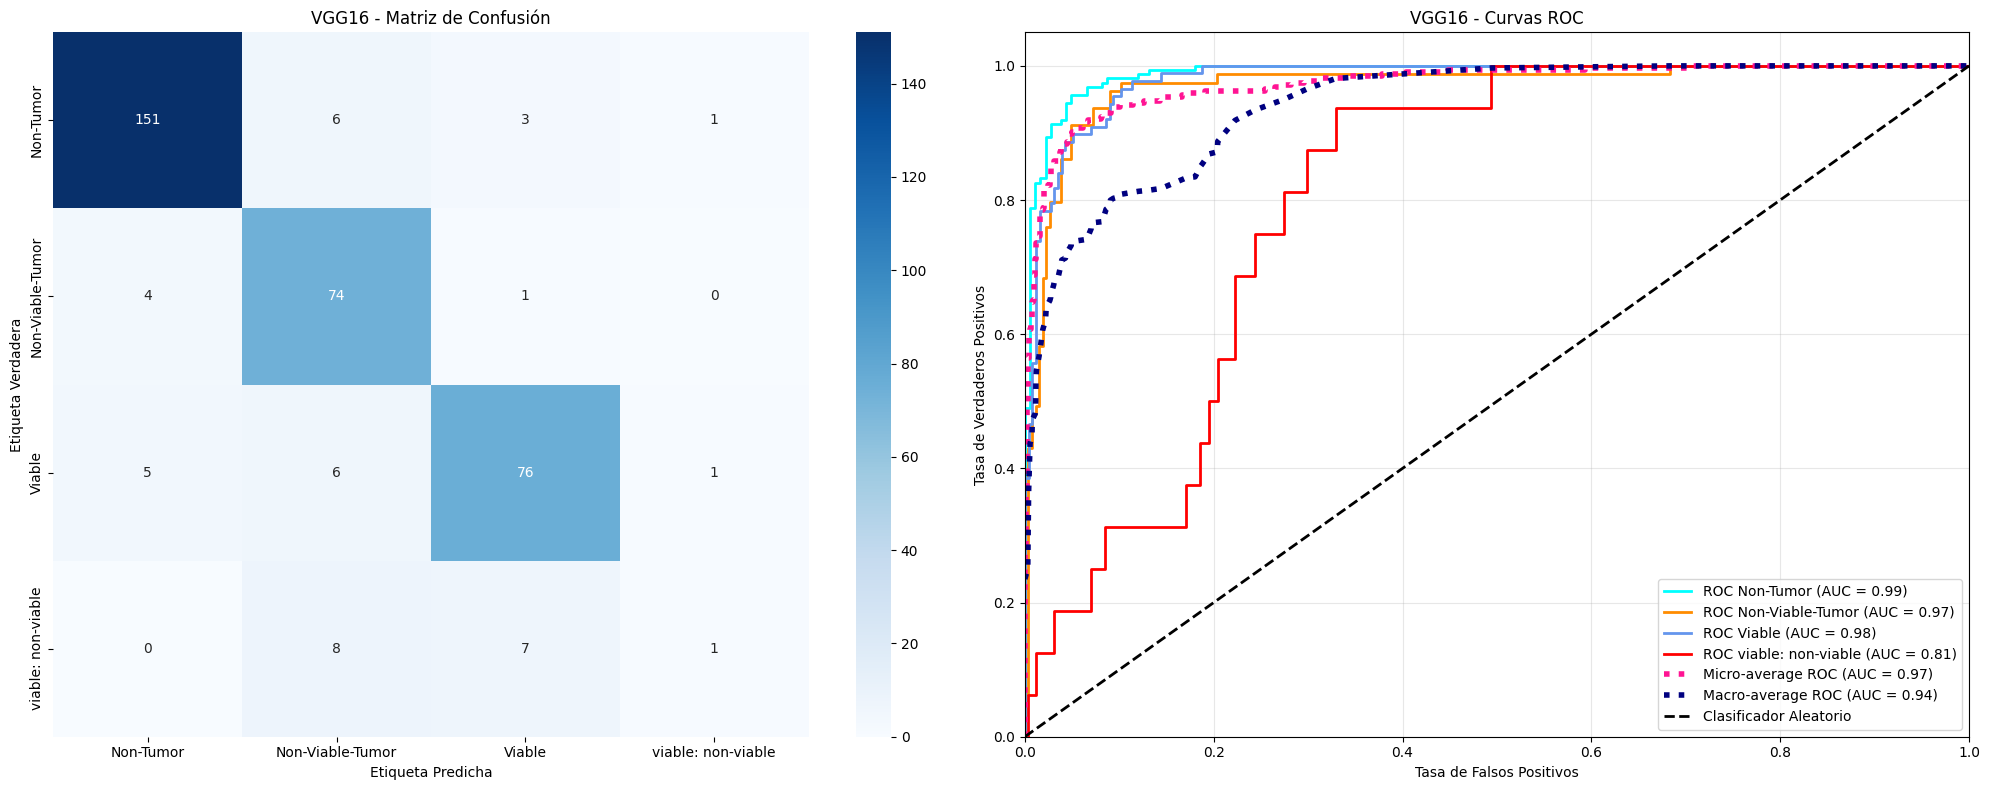


VGG16 - Coeficiente de Correlaci√≥n de Matthews: 0.8156
VGG16 - AUC Macro-average: 0.9413
VGG16 - AUC Micro-average: 0.9735

Evaluando ResNet50...
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 624ms/step

ResNet50 - Accuracy: 0.8924
ResNet50 - F1-Score (Macro): 0.6804
ResNet50 - F1-Score (Weighted): 0.8728
ResNet50 - F1-Score (Micro): 0.8924
ResNet50 - F1-Score por clase:
  Non-Tumor: 0.9415
  Non-Viable-Tumor: 0.8889
  Viable: 0.8913
  viable: non-viable: 0.0000

ResNet50 - Classification Report:
                    precision    recall  f1-score   support

         Non-Tumor       0.93      0.95      0.94       161
  Non-Viable-Tumor       0.87      0.91      0.89        79
            Viable       0.85      0.93      0.89        88
viable: non-viable       0.00      0.00      0.00        16

          accuracy                           0.89       344
         macro avg       0.66      0.70      0.68       344
      weighted avg       0.85      0.89      0.87

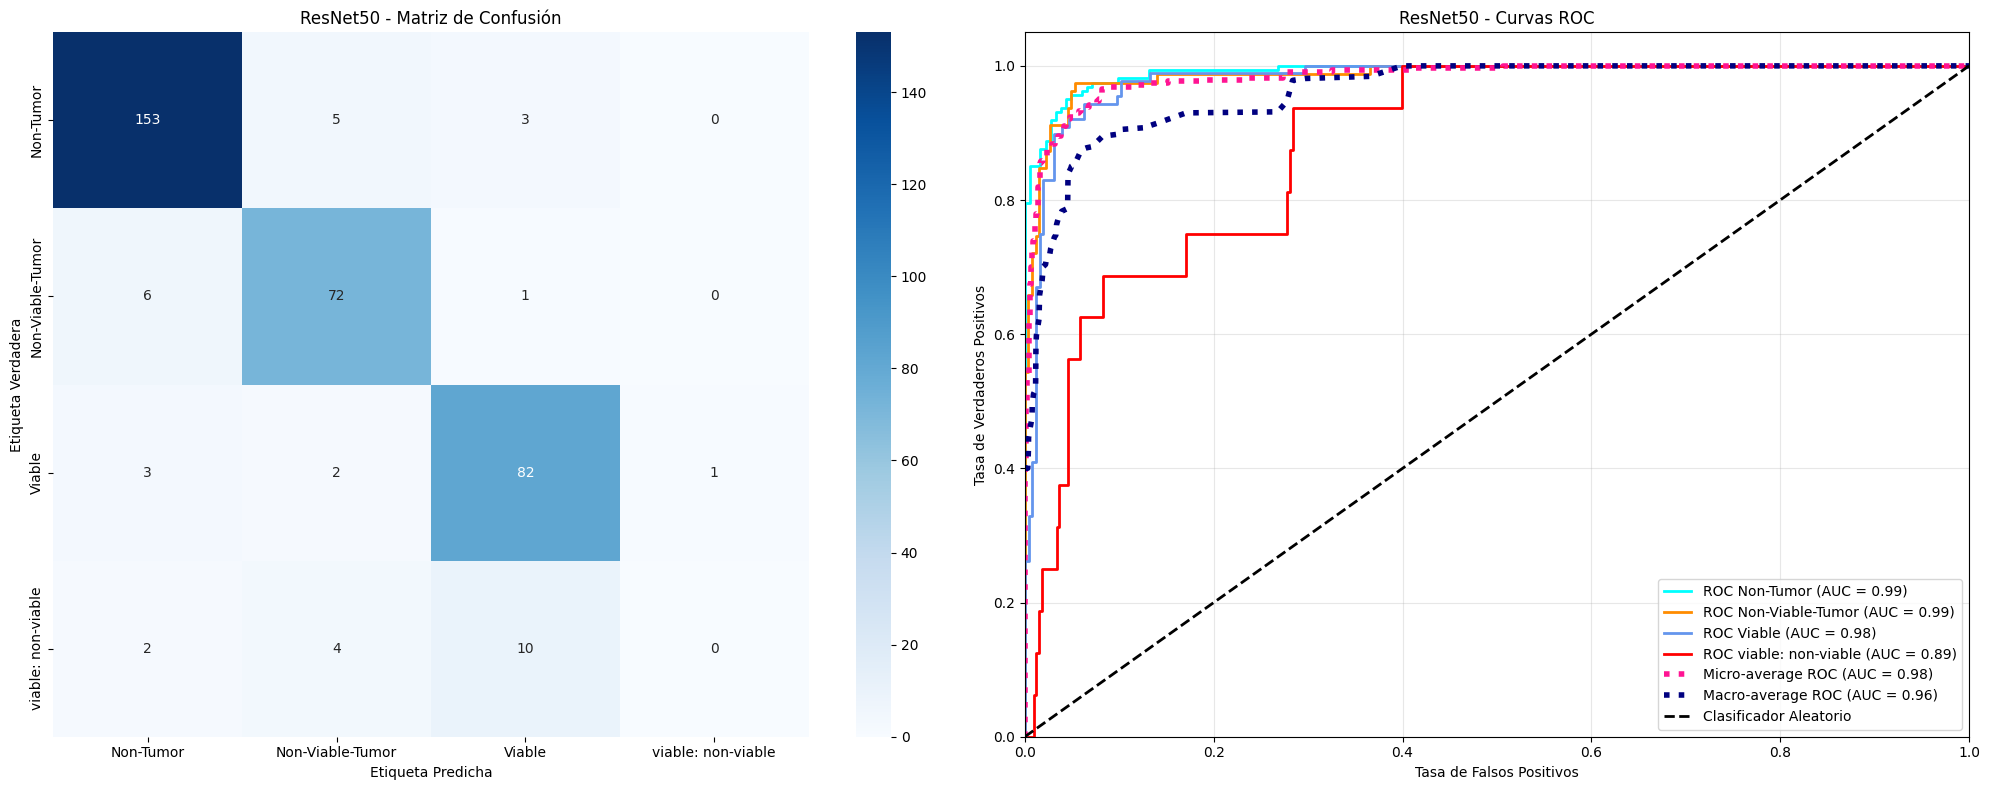


ResNet50 - Coeficiente de Correlaci√≥n de Matthews: 0.8364
ResNet50 - AUC Macro-average: 0.9626
ResNet50 - AUC Micro-average: 0.9833

Evaluando MobileNetV2...
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 471ms/step

MobileNetV2 - Accuracy: 0.8779
MobileNetV2 - F1-Score (Macro): 0.6679
MobileNetV2 - F1-Score (Weighted): 0.8582
MobileNetV2 - F1-Score (Micro): 0.8779
MobileNetV2 - F1-Score por clase:
  Non-Tumor: 0.9305
  Non-Viable-Tumor: 0.8690
  Viable: 0.8721
  viable: non-viable: 0.0000

MobileNetV2 - Classification Report:
                    precision    recall  f1-score   support

         Non-Tumor       0.91      0.96      0.93       161
  Non-Viable-Tumor       0.82      0.92      0.87        79
            Viable       0.89      0.85      0.87        88
viable: non-viable       0.00      0.00      0.00        16

          accuracy                           0.88       344
         macro avg       0.65      0.68      0.67       344
      weighted avg  

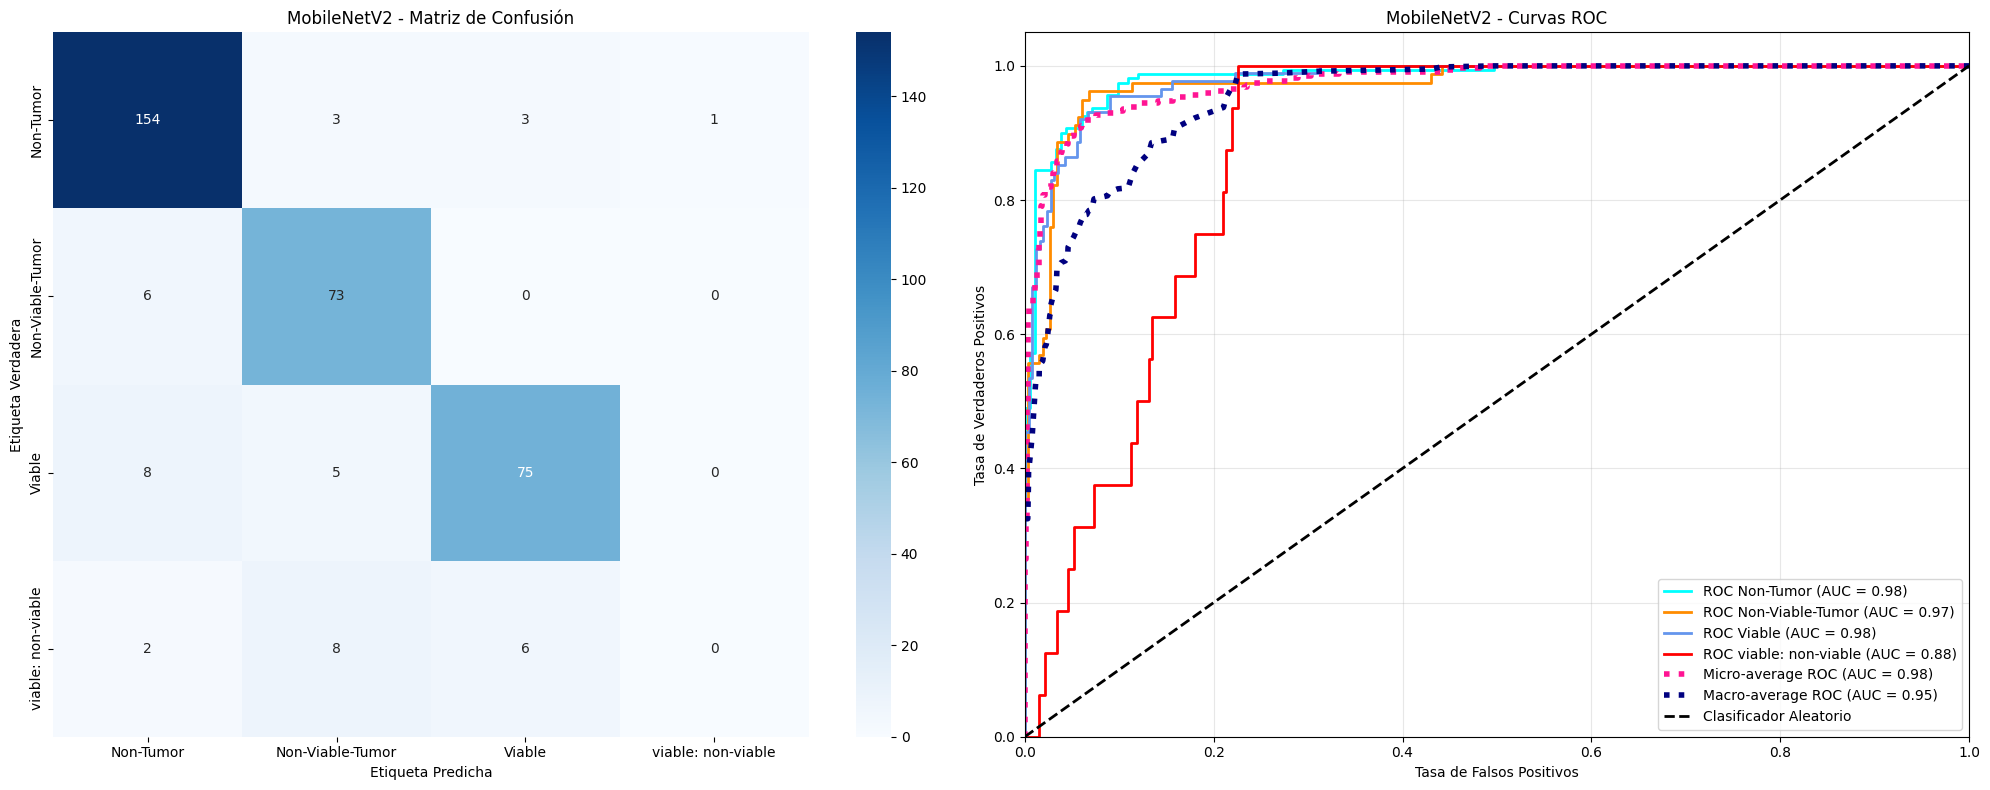


MobileNetV2 - Coeficiente de Correlaci√≥n de Matthews: 0.8137
MobileNetV2 - AUC Macro-average: 0.9549
MobileNetV2 - AUC Micro-average: 0.9752

Evaluando EfficientNetB0...
11/11 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 671ms/step

EfficientNetB0 - Accuracy: 0.8808
EfficientNetB0 - F1-Score (Macro): 0.6951
EfficientNetB0 - F1-Score (Weighted): 0.8689
EfficientNetB0 - F1-Score (Micro): 0.8808
EfficientNetB0 - F1-Score por clase:
  Non-Tumor: 0.9434
  Non-Viable-Tumor: 0.8655
  Viable: 0.8764
  viable: non-viable: 0.0952

EfficientNetB0 - Classification Report:
                    precision    recall  f1-score   support

         Non-Tumor       0.96      0.93      0.94       161
  Non-Viable-Tumor       0.80      0.94      0.87        79
            Viable       0.87      0.89      0.88        88
viable: non-viable       0.20      0.06      0.10        16

          accuracy                           0.88       344
         macro avg       0.71      0.70      0.70

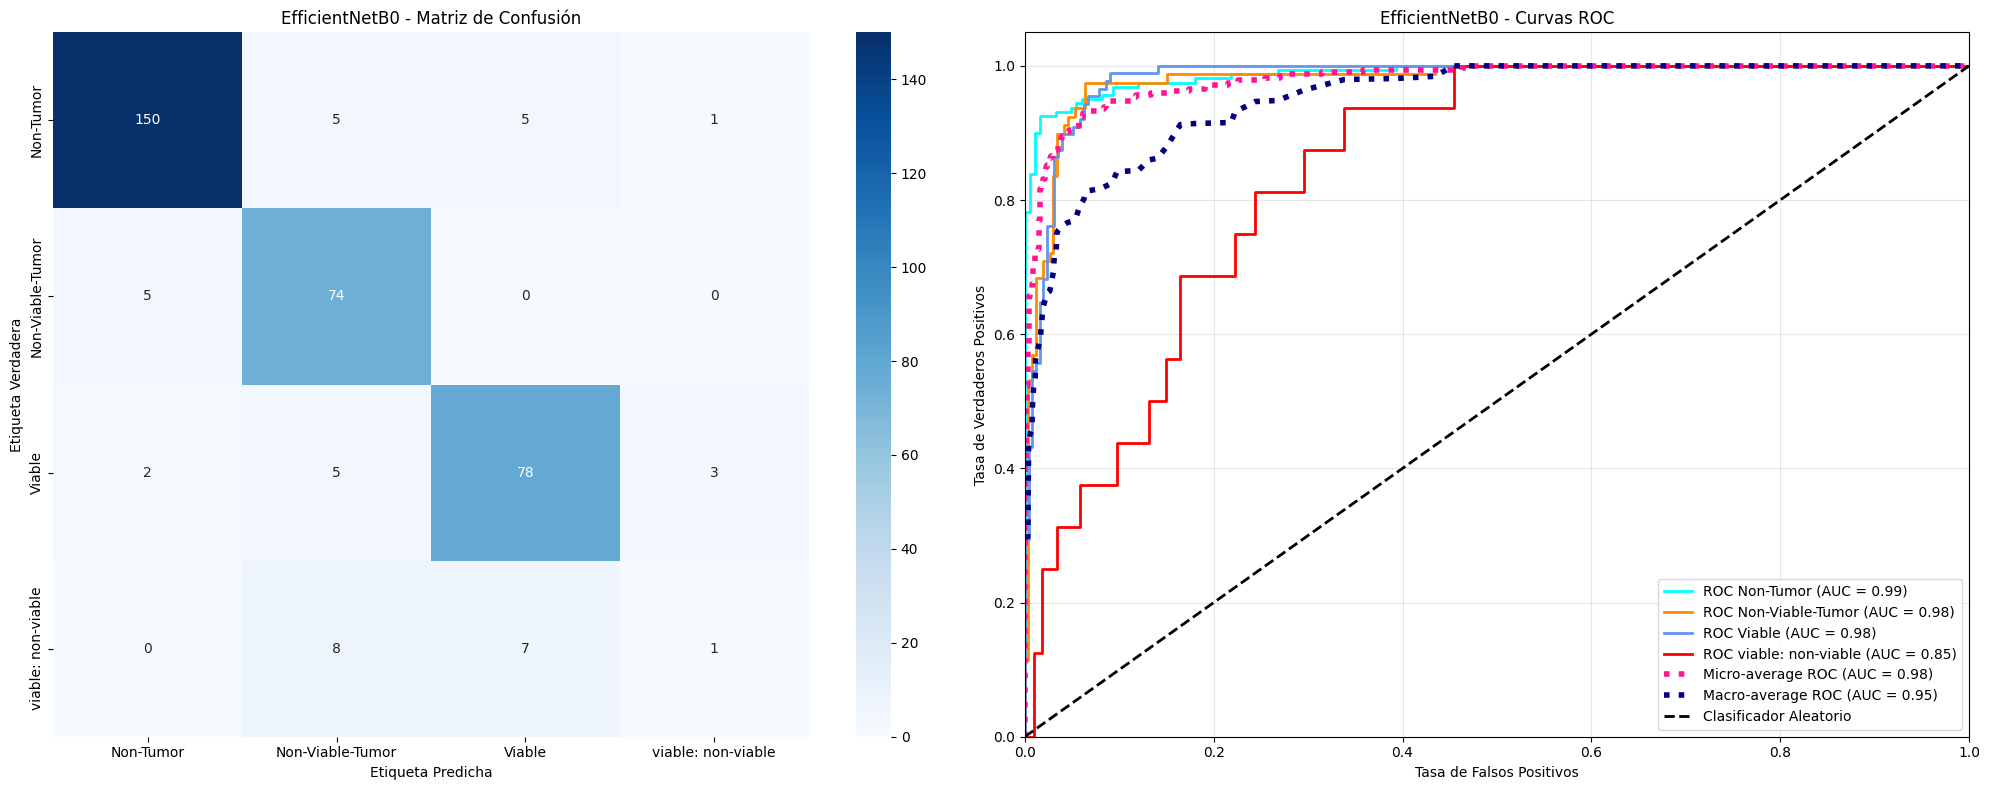


EfficientNetB0 - Coeficiente de Correlaci√≥n de Matthews: 0.8203
EfficientNetB0 - AUC Macro-average: 0.9516
EfficientNetB0 - AUC Micro-average: 0.9795


In [8]:
# Funci√≥n para evaluar un modelo
def evaluate_model(model, X_val, y_val, model_name, preprocessing_func=None):
    from sklearn.metrics import roc_curve, auc, f1_score
    from sklearn.preprocessing import label_binarize
    from itertools import cycle

    # Preprocesamiento para CNN est√°ndar
    if preprocessing_func:
        X_val_processed = np.array([preprocessing_func(img) for img in X_val])
    else:
        X_val_processed = X_val / 255.0

    # Obtener predicciones
    y_pred = model.predict(X_val_processed)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calcular m√©tricas
    accuracy = np.mean(y_pred_classes == y_val)
    print(f"\n{model_name} - Accuracy: {accuracy:.4f}")

    # F1-score optimizado para multiclase
    # Macro: Promedio no ponderado (√∫til cuando las clases est√°n desbalanceadas)
    # Weighted: Promedio ponderado por soporte (considera el desbalance de clases)
    # Micro: Calcula m√©tricas globalmente (√∫til para datasets grandes)
    f1_macro = f1_score(y_val, y_pred_classes, average='macro')
    f1_weighted = f1_score(y_val, y_pred_classes, average='weighted')
    f1_micro = f1_score(y_val, y_pred_classes, average='micro')

    print(f"{model_name} - F1-Score (Macro): {f1_macro:.4f}")
    print(f"{model_name} - F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"{model_name} - F1-Score (Micro): {f1_micro:.4f}")

    # F1-score por clase individual (muy √∫til para an√°lisis detallado)
    f1_per_class = f1_score(y_val, y_pred_classes, average=None)
    print(f"{model_name} - F1-Score por clase:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"  {class_name}: {f1_per_class[i]:.4f}")

    # Reporte de clasificaci√≥n
    report = classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_)
    print(f"\n{model_name} - Classification Report:")
    print(report)

    # Crear subplots para matriz de confusi√≥n y curvas ROC
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Matriz de confusi√≥n
    cm = confusion_matrix(y_val, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_, ax=axes[0])
    axes[0].set_title(f'{model_name} - Matriz de Confusi√≥n')
    axes[0].set_ylabel('Etiqueta Verdadera')
    axes[0].set_xlabel('Etiqueta Predicha')

    # Curvas ROC y AUC
    n_classes = len(label_encoder.classes_)

    # Binarizar las etiquetas para ROC multiclase
    y_val_bin = label_binarize(y_val, classes=range(n_classes))

    # Para casos con 4+ clases, label_binarize devuelve una matriz 2D
    # Para casos con 2 clases, devuelve un vector 1D que necesita ser reformateado
    if n_classes == 2:
        y_val_bin = np.column_stack([1 - y_val_bin, y_val_bin])

    # Calcular ROC curve y AUC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Calcular macro-average ROC curve y AUC
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plotear ROC curves
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])

    # Plotear curva ROC para cada clase
    for i, color in zip(range(n_classes), colors):
        axes[1].plot(fpr[i], tpr[i], color=color, lw=2,
                    label=f'ROC {label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})')

    # Plotear micro y macro average
    axes[1].plot(fpr["micro"], tpr["micro"],
                label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.2f})',
                color='deeppink', linestyle=':', linewidth=4)

    axes[1].plot(fpr["macro"], tpr["macro"],
                label=f'Macro-average ROC (AUC = {roc_auc["macro"]:.2f})',
                color='navy', linestyle=':', linewidth=4)

    # L√≠nea diagonal (clasificador aleatorio)
    axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Clasificador Aleatorio')

    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('Tasa de Falsos Positivos')
    axes[1].set_ylabel('Tasa de Verdaderos Positivos')
    axes[1].set_title(f'{model_name} - Curvas ROC')
    axes[1].legend(loc="lower right")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{model_name}_evaluation_metrics.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Coeficiente de Matthews (especialmente √∫til para datasets desbalanceados)
    mcc = matthews_corrcoef(y_val, y_pred_classes)
    print(f"\n{model_name} - Coeficiente de Correlaci√≥n de Matthews: {mcc:.4f}")
    print(f"{model_name} - AUC Macro-average: {roc_auc['macro']:.4f}")
    print(f"{model_name} - AUC Micro-average: {roc_auc['micro']:.4f}")

    return y_pred_classes, y_pred, roc_auc, f1_per_class

# Evaluar todos los modelos
predictions = {}
probabilities = {}
auc_scores = {}
f1_per_class_scores = {}

for name, model in models.items():
    print(f"\nEvaluando {name}...")

    if name == 'VGG16':
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name, preprocessing_func=vgg_preprocess)
    elif name == 'ResNet50':
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name, preprocessing_func=resnet_preprocess)
    elif name == 'MobileNetV2':
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name, preprocessing_func=mobilenet_preprocess)
    elif name == 'EfficientNetB0':
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name, preprocessing_func=efficientnet_preprocess)
    else:
        pred_classes, pred_probs, roc_auc, f1_classes = evaluate_model(model, X_val, y_val, name)

    predictions[name] = pred_classes
    probabilities[name] = pred_probs
    auc_scores[name] = roc_auc
    f1_per_class_scores[name] = f1_classes

### Resumen comparativo de todas las m√©tricas

RESUMEN COMPARATIVO DE MODELOS
        Modelo  Accuracy  F1-Score (Macro)  F1-Score (Weighted)  F1-Score (Micro)  AUC (Macro)  AUC (Micro)    MCC
         VGG16    0.8779            0.6925               0.8639            0.8779       0.9413       0.9735 0.8156
      ResNet50    0.8924            0.6804               0.8728            0.8924       0.9626       0.9833 0.8364
   MobileNetV2    0.8779            0.6679               0.8582            0.8779       0.9549       0.9752 0.8137
EfficientNetB0    0.8808            0.6951               0.8689            0.8808       0.9516       0.9795 0.8203


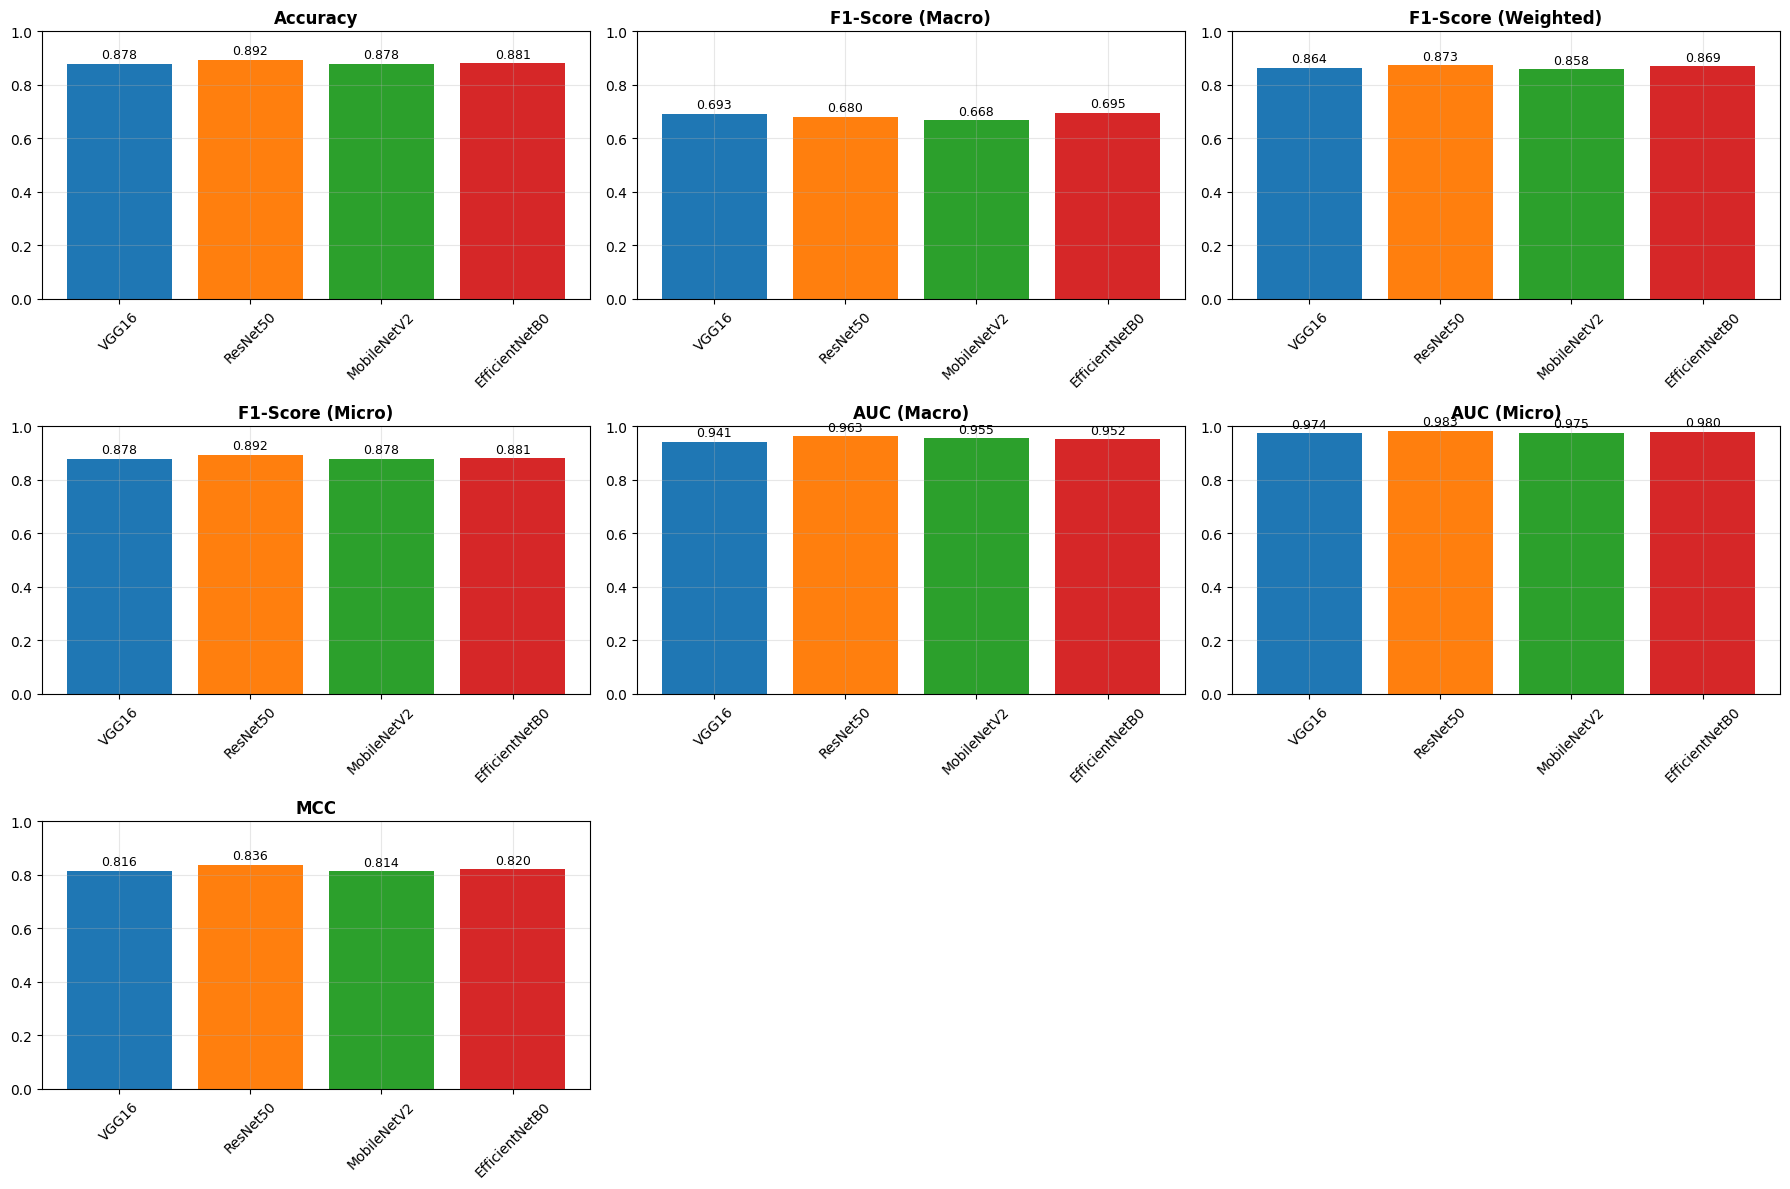


AN√ÅLISIS F1-SCORE POR CLASE


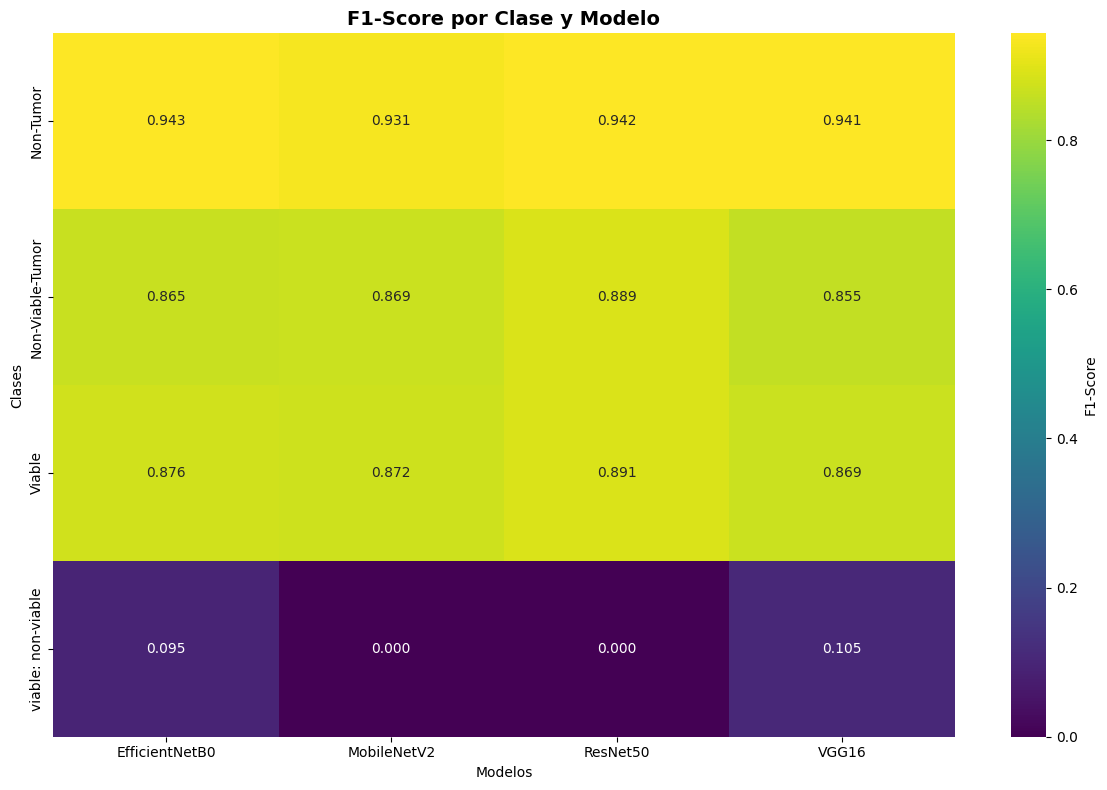


MEJORES MODELOS POR M√âTRICA
Accuracy            : ResNet50        (0.8924)
F1-Score (Macro)    : EfficientNetB0  (0.6951)
F1-Score (Weighted) : ResNet50        (0.8728)
F1-Score (Micro)    : ResNet50        (0.8924)
AUC (Macro)         : ResNet50        (0.9626)
AUC (Micro)         : ResNet50        (0.9833)
MCC                 : ResNet50        (0.8364)

MEJORES MODELOS POR CLASE (F1-Score)
Non-Tumor           : EfficientNetB0  (0.9434)
Non-Viable-Tumor    : ResNet50        (0.8889)
Viable              : ResNet50        (0.8913)
viable: non-viable  : VGG16           (0.1053)



In [9]:
from sklearn.metrics import accuracy_score, f1_score

print("="*80)
print("RESUMEN COMPARATIVO DE MODELOS")
print("="*80)

# Crear tabla resumen
summary_data = []
for name in models.keys():
    pred_classes = predictions[name]
    auc_macro = auc_scores[name]['macro']
    auc_micro = auc_scores[name]['micro']

    accuracy = accuracy_score(y_val, pred_classes)
    f1_macro = f1_score(y_val, pred_classes, average='macro')
    f1_weighted = f1_score(y_val, pred_classes, average='weighted')
    f1_micro = f1_score(y_val, pred_classes, average='micro')
    mcc = matthews_corrcoef(y_val, pred_classes)

    summary_data.append({
        'Modelo': name,
        'Accuracy': accuracy,
        'F1-Score (Macro)': f1_macro,
        'F1-Score (Weighted)': f1_weighted,
        'F1-Score (Micro)': f1_micro,
        'AUC (Macro)': auc_macro,
        'AUC (Micro)': auc_micro,
        'MCC': mcc
    })

# Convertir a DataFrame para mejor visualizaci√≥n
summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

print(summary_df.to_string(index=False))

# Crear gr√°fico comparativo de m√©tricas
plt.figure(figsize=(18, 12))

metrics = ['Accuracy', 'F1-Score (Macro)', 'F1-Score (Weighted)', 'F1-Score (Micro)', 'AUC (Macro)', 'AUC (Micro)', 'MCC']
x_pos = np.arange(len(models))
width = 0.15

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, metric in enumerate(metrics):
    plt.subplot(3, 3, i+1)
    values = [summary_df[summary_df['Modelo'] == name][metric].iloc[0] for name in models.keys()]
    bars = plt.bar(x_pos, values, color=colors)

    plt.title(f'{metric}', fontsize=12, fontweight='bold')
    plt.xticks(x_pos, models.keys(), rotation=45)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)

    # A√±adir valores en las barras
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('models_comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# An√°lisis detallado por clase
print("\n" + "="*80)
print("AN√ÅLISIS F1-SCORE POR CLASE")
print("="*80)

# Crear DataFrame para F1-scores por clase
class_f1_data = []
for model_name in models.keys():
    for i, class_name in enumerate(label_encoder.classes_):
        class_f1_data.append({
            'Modelo': model_name,
            'Clase': class_name,
            'F1-Score': f1_per_class_scores[model_name][i]
        })

class_f1_df = pd.DataFrame(class_f1_data)

# Crear heatmap de F1-scores por clase
plt.figure(figsize=(12, 8))
pivot_df = class_f1_df.pivot(index='Clase', columns='Modelo', values='F1-Score')
sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.3f', cbar_kws={'label': 'F1-Score'})
plt.title('F1-Score por Clase y Modelo', fontsize=14, fontweight='bold')
plt.ylabel('Clases')
plt.xlabel('Modelos')
plt.tight_layout()
plt.savefig('f1_score_by_class_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Encontrar el mejor modelo por cada m√©trica
print("\n" + "="*50)
print("MEJORES MODELOS POR M√âTRICA")
print("="*50)

for metric in metrics:
    best_model_idx = summary_df[metric].idxmax()
    best_model = summary_df.loc[best_model_idx, 'Modelo']
    best_value = summary_df.loc[best_model_idx, metric]
    print(f"{metric:20s}: {best_model:15s} ({best_value:.4f})")

# Encontrar el mejor modelo por clase
print("\n" + "="*50)
print("MEJORES MODELOS POR CLASE (F1-Score)")
print("="*50)

for class_name in label_encoder.classes_:
    class_scores = class_f1_df[class_f1_df['Clase'] == class_name]
    best_idx = class_scores['F1-Score'].idxmax()
    best_model = class_scores.loc[best_idx, 'Modelo']
    best_score = class_scores.loc[best_idx, 'F1-Score']
    print(f"{class_name:20s}: {best_model:15s} ({best_score:.4f})")

print("\n" + "="*80)

### M√©tricas adicionales que podr√≠an ser de utilidad en aplicaciones m√©dicas

M√âTRICAS ADICIONALES PARA MODELOS M√âDICOS
M√âTRICAS ADICIONALES:
        Modelo  Balanced Accuracy  Cohen Kappa  Log Loss  Top-2 Accuracy  Precision (Macro)  Recall (Macro)  Specificity (Macro)
         VGG16             0.7002       0.8134    0.4291          0.9419             0.7345          0.7002               0.9566
      ResNet50             0.6984       0.8345    0.3017          0.9709             0.6636          0.6984               0.9602
   MobileNetV2             0.6832       0.8112    0.3749          0.9622             0.6547          0.6832               0.9535
EfficientNetB0             0.7043       0.8187    0.3376          0.9535             0.7066          0.7043               0.9587


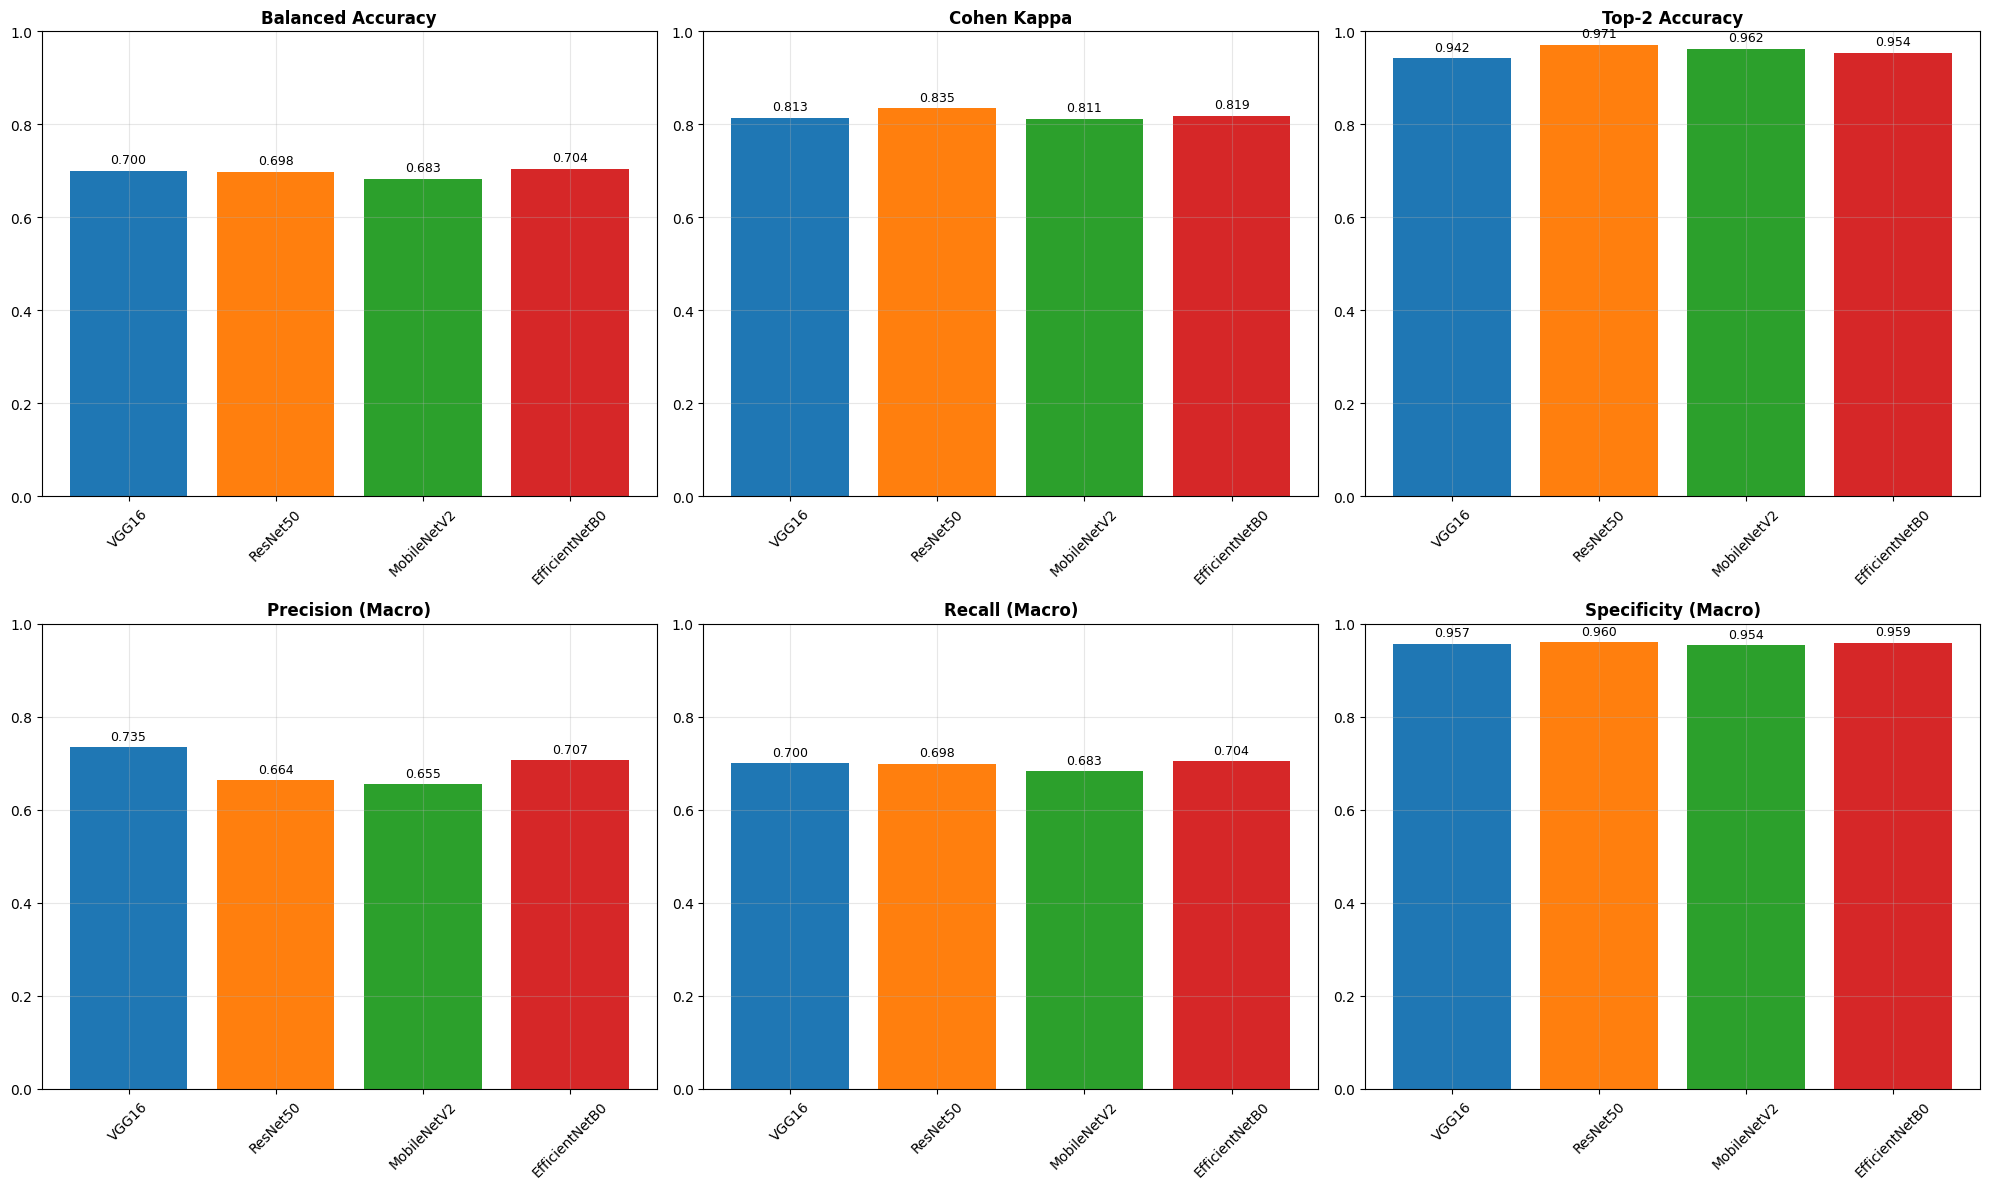


AN√ÅLISIS DE SENSIBILIDAD Y ESPECIFICIDAD POR CLASE


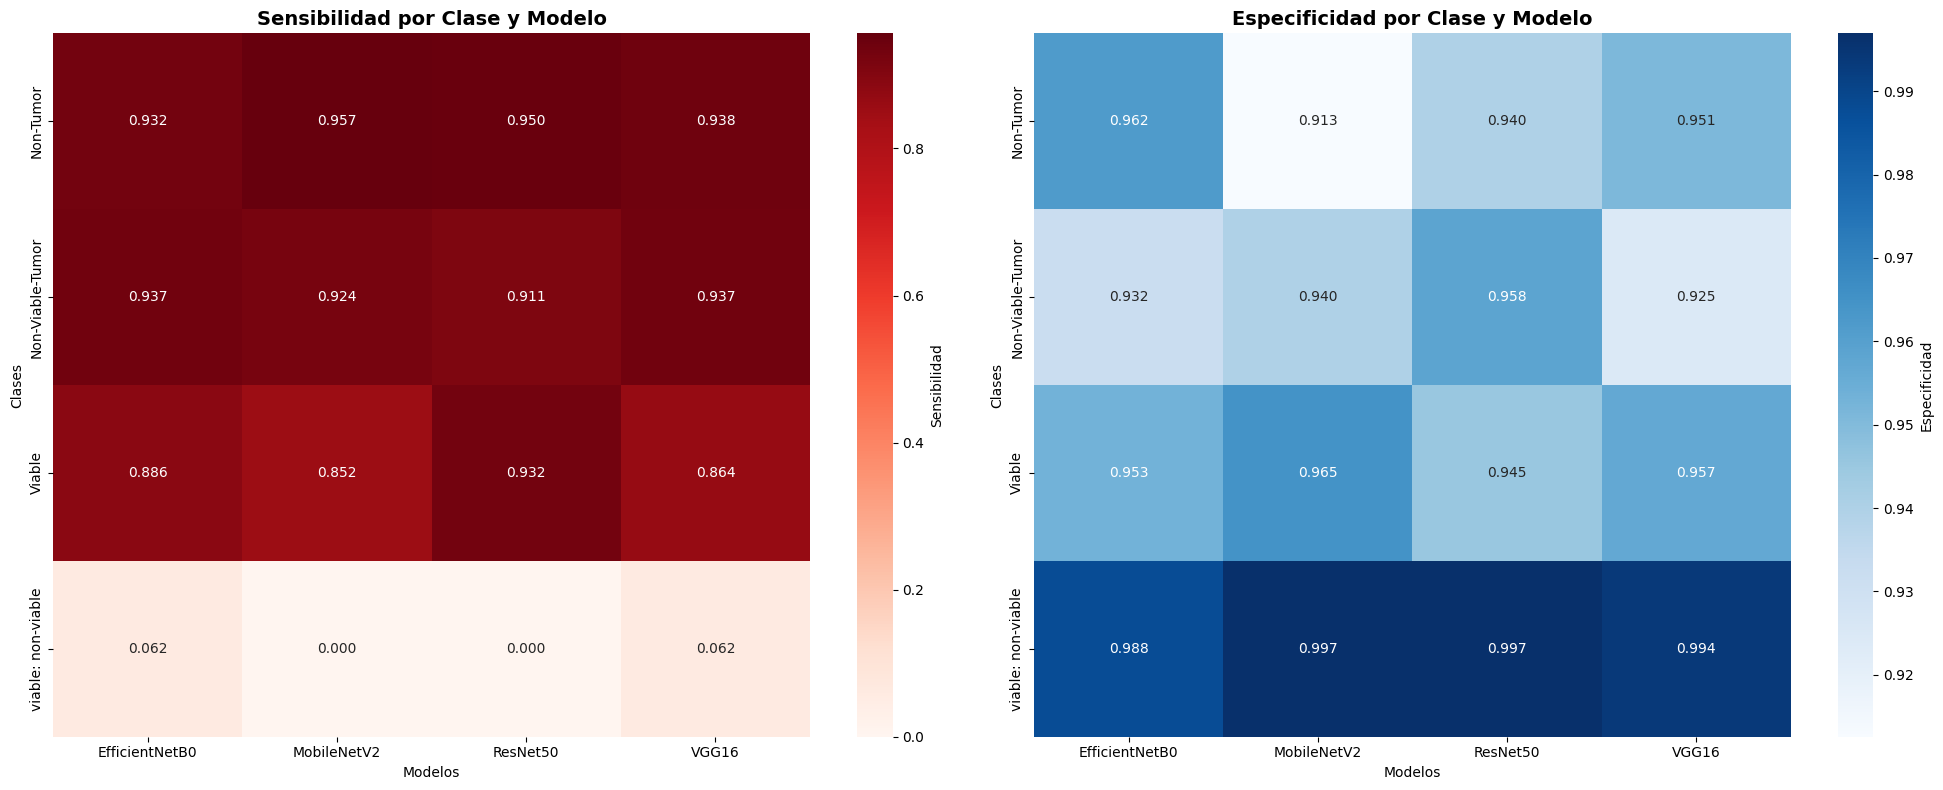


EXPLICACI√ìN DE M√âTRICAS PARA MODELOS M√âDICOS

üéØ M√âTRICAS CLAVE PARA CLASIFICACI√ìN M√âDICA MULTICLASE:

1. BALANCED ACCURACY: 
   - Promedio de recall de cada clase
   - Ideal para datos desbalanceados como el nuestro
   - Valor √≥ptimo: cercano a 1.0

2. COHEN'S KAPPA:
   - Mide concordancia corrigiendo el azar
   - 0.0 = acuerdo casual, 1.0 = acuerdo perfecto
   - >0.8 = excelente, >0.6 = bueno

3. LOG LOSS:
   - Penaliza predicciones incorrectas con alta confianza
   - Valor √≥ptimo: cercano a 0.0
   - Importante en diagn√≥stico m√©dico (evita sobre-confianza)

4. TOP-2 ACCURACY:
   - % de casos donde la clase correcta est√° en top 2 predicciones
   - √ötil en diagn√≥stico diferencial
   - Valor √≥ptimo: >0.9

5. SENSIBILIDAD (RECALL):
   - Capacidad de detectar casos positivos
   - Cr√≠tica para detectar casos de c√°ncer
   - TP / (TP + FN)

6. ESPECIFICIDAD:
   - Capacidad de evitar falsos positivos
   - Importante para evitar diagn√≥sticos err√≥neos
   - TN / (TN + FP)



In [10]:
from sklearn.metrics import (
    balanced_accuracy_score,
    cohen_kappa_score,
    log_loss,
    precision_recall_fscore_support,
    top_k_accuracy_score
)

print("="*80)
print("M√âTRICAS ADICIONALES PARA MODELOS M√âDICOS")
print("="*80)

# Calcular m√©tricas adicionales para cada modelo
additional_metrics = []

for name in models.keys():
    pred_classes = predictions[name]
    pred_probs = probabilities[name]

    # 1. Balanced Accuracy: Especialmente importante para datos desbalanceados
    balanced_acc = balanced_accuracy_score(y_val, pred_classes)

    # 2. Cohen's Kappa: Mide concordancia considerando el azar
    kappa = cohen_kappa_score(y_val, pred_classes)

    # 3. Log Loss: Penaliza predicciones incorrectas con alta confianza
    logloss = log_loss(y_val, pred_probs)

    # 4. Top-2 Accuracy: √ötil en diagn√≥stico m√©dico (si la clase correcta est√° en top 2)
    top2_acc = top_k_accuracy_score(y_val, pred_probs, k=2)

    # 5. Precisi√≥n, Recall y F1 por clase (macro avg)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_val, pred_classes, average='macro'
    )

    # 6. Especificidad promedio (importante en diagn√≥stico m√©dico)
    # Calcular especificidad para cada clase
    cm = confusion_matrix(y_val, pred_classes)
    specificities = []

    for i in range(len(label_encoder.classes_)):
        # Para clase i: especificidad = TN / (TN + FP)
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)

    avg_specificity = np.mean(specificities)

    additional_metrics.append({
        'Modelo': name,
        'Balanced Accuracy': balanced_acc,
        'Cohen Kappa': kappa,
        'Log Loss': logloss,
        'Top-2 Accuracy': top2_acc,
        'Precision (Macro)': precision,
        'Recall (Macro)': recall,
        'Specificity (Macro)': avg_specificity
    })

# Crear DataFrame para m√©tricas adicionales
additional_df = pd.DataFrame(additional_metrics)
additional_df = additional_df.round(4)

print("M√âTRICAS ADICIONALES:")
print(additional_df.to_string(index=False))

# Visualizaci√≥n de m√©tricas adicionales
plt.figure(figsize=(20, 12))

additional_metrics_names = [
    'Balanced Accuracy', 'Cohen Kappa', 'Top-2 Accuracy',
    'Precision (Macro)', 'Recall (Macro)', 'Specificity (Macro)'
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
x_pos = np.arange(len(models))

for i, metric in enumerate(additional_metrics_names):
    plt.subplot(2, 3, i+1)
    values = [additional_df[additional_df['Modelo'] == name][metric].iloc[0] for name in models.keys()]
    bars = plt.bar(x_pos, values, color=colors)

    plt.title(f'{metric}', fontsize=12, fontweight='bold')
    plt.xticks(x_pos, models.keys(), rotation=45)

    # Ajustar ylim seg√∫n la m√©trica
    if metric == 'Log Loss':
        plt.ylim(0, max(values) * 1.1)
    else:
        plt.ylim(0, 1)

    plt.grid(True, alpha=0.3)

    # A√±adir valores en las barras
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('additional_medical_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# An√°lisis de sensibilidad y especificidad por clase
print("\n" + "="*80)
print("AN√ÅLISIS DE SENSIBILIDAD Y ESPECIFICIDAD POR CLASE")
print("="*80)

sensitivity_specificity_data = []

for model_name in models.keys():
    pred_classes = predictions[model_name]
    cm = confusion_matrix(y_val, pred_classes)

    for i, class_name in enumerate(label_encoder.classes_):
        # Sensibilidad (Recall) = TP / (TP + FN)
        tp = cm[i, i]
        fn = np.sum(cm[i, :]) - tp
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

        # Especificidad = TN / (TN + FP)
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - tp
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

        sensitivity_specificity_data.append({
            'Modelo': model_name,
            'Clase': class_name,
            'Sensibilidad': sensitivity,
            'Especificidad': specificity
        })

sens_spec_df = pd.DataFrame(sensitivity_specificity_data)

# Crear heatmaps para sensibilidad y especificidad
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap de Sensibilidad
sens_pivot = sens_spec_df.pivot(index='Clase', columns='Modelo', values='Sensibilidad')
sns.heatmap(sens_pivot, annot=True, cmap='Reds', fmt='.3f',
            cbar_kws={'label': 'Sensibilidad'}, ax=axes[0])
axes[0].set_title('Sensibilidad por Clase y Modelo', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Clases')
axes[0].set_xlabel('Modelos')

# Heatmap de Especificidad
spec_pivot = sens_spec_df.pivot(index='Clase', columns='Modelo', values='Especificidad')
sns.heatmap(spec_pivot, annot=True, cmap='Blues', fmt='.3f',
            cbar_kws={'label': 'Especificidad'}, ax=axes[1])
axes[1].set_title('Especificidad por Clase y Modelo', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Clases')
axes[1].set_xlabel('Modelos')

plt.tight_layout()
plt.savefig('sensitivity_specificity_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("EXPLICACI√ìN DE M√âTRICAS PARA MODELOS M√âDICOS")
print("="*80)
print("""
üéØ M√âTRICAS CLAVE PARA CLASIFICACI√ìN M√âDICA MULTICLASE:

1. BALANCED ACCURACY:
   - Promedio de recall de cada clase
   - Ideal para datos desbalanceados como el nuestro
   - Valor √≥ptimo: cercano a 1.0

2. COHEN'S KAPPA:
   - Mide concordancia corrigiendo el azar
   - 0.0 = acuerdo casual, 1.0 = acuerdo perfecto
   - >0.8 = excelente, >0.6 = bueno

3. LOG LOSS:
   - Penaliza predicciones incorrectas con alta confianza
   - Valor √≥ptimo: cercano a 0.0
   - Importante en diagn√≥stico m√©dico (evita sobre-confianza)

4. TOP-2 ACCURACY:
   - % de casos donde la clase correcta est√° en top 2 predicciones
   - √ötil en diagn√≥stico diferencial
   - Valor √≥ptimo: >0.9

5. SENSIBILIDAD (RECALL):
   - Capacidad de detectar casos positivos
   - Cr√≠tica para detectar casos de c√°ncer
   - TP / (TP + FN)

6. ESPECIFICIDAD:
   - Capacidad de evitar falsos positivos
   - Importante para evitar diagn√≥sticos err√≥neos
   - TN / (TN + FP)

üè• CONSIDERACIONES M√âDICAS:
- En c√°ncer: SENSIBILIDAD alta es cr√≠tica (no perder casos)
- En diagn√≥stico: ESPECIFICIDAD alta evita tratamientos innecesarios
- BALANCED ACCURACY es mejor que accuracy simple en datos desbalanceados
- COHEN'S KAPPA considera el azar (importante en m√∫ltiples clases)
""")

# Ranking consolidado considerando todas las m√©tricas
print("\n" + "="*50)
print("RANKING CONSOLIDADO DE MODELOS")
print("="*50)

# Combinar todas las m√©tricas (normalizadas)
consolidated_data = []
for name in models.keys():
    # M√©tricas principales (a maximizar)
    main_row = summary_df[summary_df['Modelo'] == name].iloc[0]
    add_row = additional_df[additional_df['Modelo'] == name].iloc[0]

    # Normalizar Log Loss (a minimizar) -> 1 - normalized_log_loss
    max_log_loss = additional_df['Log Loss'].max()
    normalized_log_loss = 1 - (add_row['Log Loss'] / max_log_loss)

    score = (
        main_row['F1-Score (Macro)'] * 0.20 +      # F1 Macro (importante para balance)
        main_row['F1-Score (Weighted)'] * 0.15 +   # F1 Weighted
        add_row['Balanced Accuracy'] * 0.20 +      # Balanced Accuracy (clave en desbalance)
        add_row['Cohen Kappa'] * 0.15 +            # Kappa (concordancia)
        main_row['MCC'] * 0.10 +                   # MCC (correlaci√≥n)
        add_row['Top-2 Accuracy'] * 0.10 +         # Top-2 (diagn√≥stico diferencial)
        normalized_log_loss * 0.10                 # Log Loss normalizado
    )

    consolidated_data.append({
        'Modelo': name,
        'Score Consolidado': score
    })

consolidated_df = pd.DataFrame(consolidated_data)
consolidated_df = consolidated_df.sort_values('Score Consolidado', ascending=False)
consolidated_df['Score Consolidado'] = consolidated_df['Score Consolidado'].round(4)

print("RANKING FINAL (Score Consolidado):")
for i, row in consolidated_df.iterrows():
    print(f"{row.name+1:2d}. {row['Modelo']:15s}: {row['Score Consolidado']:.4f}")

print("\n" + "="*80)

### Prueba de McNemar para comparaci√≥n de modelos

In [11]:
# Funci√≥n para realizar la prueba de McNemar
def mcnemar_test(model1_preds, model2_preds, y_true, model1_name, model2_name):
    # Crear tabla de contingencia
    correct1 = model1_preds == y_true
    correct2 = model2_preds == y_true

    # Tabla: [correcto/correcto, correcto/incorrecto, incorrecto/correcto, incorrecto/incorrecto]
    table = np.zeros((2, 2))
    table[0, 0] = np.sum(correct1 & correct2)  # Ambos correctos
    table[0, 1] = np.sum(correct1 & ~correct2)  # Modelo 1 correcto, Modelo 2 incorrecto
    table[1, 0] = np.sum(~correct1 & correct2)  # Modelo 1 incorrecto, Modelo 2 correcto
    table[1, 1] = np.sum(~correct1 & ~correct2)  # Ambos incorrectos

    # Realizar la prueba de McNemar
    result = mcnemar(table, exact=True)

    print(f"\nPrueba de McNemar: {model1_name} vs {model2_name}")
    print(f"Tabla de contingencia:")
    print(f"                    | {model2_name} correcto | {model2_name} incorrecto")
    print(f"--------------------|---------------------|----------------------")
    print(f"{model1_name} correcto   | {table[0, 0]:.0f}                | {table[0, 1]:.0f}")
    print(f"{model1_name} incorrecto | {table[1, 0]:.0f}                | {table[1, 1]:.0f}")
    print(f"\nEstad√≠stico: {result.statistic:.4f}")
    print(f"P-valor: {result.pvalue:.4f}")

    if result.pvalue < 0.05:
        print(f"Conclusi√≥n: Hay una diferencia estad√≠sticamente significativa entre {model1_name} y {model2_name}.")
    else:
        print(f"Conclusi√≥n: No hay una diferencia estad√≠sticamente significativa entre {model1_name} y {model2_name}.")

# Realizar la prueba de McNemar para cada par de modelos
model_names = list(models.keys())
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        mcnemar_test(
            predictions[model_names[i]],
            predictions[model_names[j]],
            y_val,
            model_names[i],
            model_names[j]
        )


Prueba de McNemar: VGG16 vs ResNet50
Tabla de contingencia:
                    | ResNet50 correcto | ResNet50 incorrecto
--------------------|---------------------|----------------------
VGG16 correcto   | 294                | 8
VGG16 incorrecto | 13                | 29

Estad√≠stico: 8.0000
P-valor: 0.3833
Conclusi√≥n: No hay una diferencia estad√≠sticamente significativa entre VGG16 y ResNet50.

Prueba de McNemar: VGG16 vs MobileNetV2
Tabla de contingencia:
                    | MobileNetV2 correcto | MobileNetV2 incorrecto
--------------------|---------------------|----------------------
VGG16 correcto   | 288                | 14
VGG16 incorrecto | 14                | 28

Estad√≠stico: 14.0000
P-valor: 1.0000
Conclusi√≥n: No hay una diferencia estad√≠sticamente significativa entre VGG16 y MobileNetV2.

Prueba de McNemar: VGG16 vs EfficientNetB0
Tabla de contingencia:
                    | EfficientNetB0 correcto | EfficientNetB0 incorrecto
--------------------|--------------------

### C√≥digo de ejemplo para inferencia con los modelos entrenados

In [12]:
# Funci√≥n para cargar un modelo y realizar inferencia
def load_model_and_predict(model_path, image_path, class_mapping, model_type=None):
    # Cargar imagen
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)

    # Asegurarse de que la imagen tiene 3 canales
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 1:
        img_array = np.concatenate([img_array, img_array, img_array], axis=-1)
    elif img_array.shape[2] == 4:  # RGBA
        img_array = img_array[:, :, :3]

    # Preprocesamiento seg√∫n el tipo de modelo
    if model_type == 'vgg16':
        img_processed = vgg_preprocess(np.expand_dims(img_array, axis=0))
    elif model_type == 'resnet50':
        img_processed = resnet_preprocess(np.expand_dims(img_array, axis=0))
    elif model_type == 'mobilenetv2':
        img_processed = mobilenet_preprocess(np.expand_dims(img_array, axis=0))
    elif model_type == 'efficientnetb0':
        img_processed = efficientnet_preprocess(np.expand_dims(img_array, axis=0))
    else:
        img_processed = np.expand_dims(img_array, axis=0) / 255.0

    # Cargar modelo
    model = load_model(model_path)

    # Realizar predicci√≥n
    prediction = model.predict(img_processed)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Devolver la clase predicha
    return class_mapping[predicted_class]

# Ejemplo de uso para inferencia con cada modelo
print("\nEjemplo de c√≥digo para inferencia con cada modelo:")
print("""
# Ejemplo de inferencia con modelos entrenados
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

def predict_with_model(model_path, image_path, preprocess_function=None):
    # Cargar imagen
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)

    # Asegurarse de que tiene 3 canales
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)

    # Preprocesar imagen
    if preprocess_function:
        img_processed = preprocess_function(np.expand_dims(img_array, axis=0))
    else:
        img_processed = np.expand_dims(img_array, axis=0) / 255.0

    # Cargar modelo y predecir
    model = load_model(model_path)
    prediction = model.predict(img_processed)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Mapeo de clases
    class_mapping = {0: 'Non-Tumor', 1: 'Non-Viable-Tumor', 2: 'Viable'}
    return class_mapping[predicted_class]
""")


Ejemplo de c√≥digo para inferencia con cada modelo:

# Ejemplo de inferencia con modelos entrenados
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image

def predict_with_model(model_path, image_path, preprocess_function=None):
    # Cargar imagen
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = np.array(img)

    # Asegurarse de que tiene 3 canales
    if len(img_array.shape) == 2:
        img_array = np.stack([img_array, img_array, img_array], axis=-1)

    # Preprocesar imagen
    if preprocess_function:
        img_processed = preprocess_function(np.expand_dims(img_array, axis=0))
    else:
        img_processed = np.expand_dims(img_array, axis=0) / 255.0

    # Cargar modelo y predecir
    model = load_model(model_path)
    prediction = model.predict(img_processed)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Mapeo de clases
    class_mapping = {0: 'Non-Tumor', 1: 'Non-Viable-Tumor', 2: 'Viable'}